# Comparison of Turbidity from Seapoint and Sea Bird Sensors

**Purpose:** This notebook details the process used to evaluate performance of two sensors that measured turbidity at the Coastal Pioneer Mid-Atlantic Bight (MAB) Array site during At-Sea Test 3 (AST3). 

**Approach:** We load and parse data from two Seapoint Turbidity Meters (TURBD) and two Sea-Bird Fluorometers (FLORT) that have been calibrated to measure turbidity with the backscatter (700 nm) channel. After evaluating the burst average on the FLORT datasets, we explore the relationship of TURBD turbidity to FLORT turbidity through timeseries, scatter plots, and linear regressions throughout AST3. We then compare brief sections of all four time series with turbidity measured during a CTD cast shortly after the deployment of mooring AS03CPSM for validation.

In [1]:
# Import libraries used in this notebook
from concurrent.futures import ThreadPoolExecutor
import requests
import os
import glob
import re
from datetime import date

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from bs4 import BeautifulSoup as bs
from urllib.parse import urljoin, urlparse
from sklearn.linear_model import LinearRegression


from Parsers.parsers import TURBD, FLORT

## Import data files and save as NetCDFs 

In [5]:
# Define functions for importing, downloading, or parsing data
os.makedirs(os.path.expanduser("~/ast3_turbidity_data"), exist_ok=True)
savepath = os.path.abspath(os.path.expanduser("~/ast3_turbidity_data/"))
def download_file(url, savepath=savepath):
    response = requests.get(url)
    if response.status_code == 200:
        filename = response.url.split("/")[-1]
    else:
        filename = url.split("/")[-1]
    with open("/".join([savepath, filename]), mode="wb") as file:
        file.write(response.content)
    print(f"Downloaded file {filename}")
    
# Define functions to download multiple files from a URL in parallel
def is_valid(url):
    """ Checks whether URL is valid
    """
    parsed = urlparse(url)
    return bool(parsed.netloc) and bool(parsed.scheme)

def get_file_urls(url: str, instr: str, start_date: int, end_date: int):
    """ Returns URLS to any .log files on the page.
    """
    soup = bs(requests.get(url).content, "html.parser")
    urls = []
    for log in tqdm(soup.find_all("a", string=re.compile(instr+".log\Z")), "Finding logger files"):
        log_url = log.attrs.get("href")
        if int(log_url[:8]) >= start_date and int(log_url[:8]) <= end_date:
            log_url = urljoin(url, log_url)
            if is_valid(log_url):
                urls.append(log_url)
        else:
            continue
    return urls

### Download and parse TURBD telemetered data

In [ ]:
# Create response object for HTML request of telemetered NSIF TURBD data
url = "https://rawdata-west.oceanobservatories.org/files/AS03CPSM/D00001/cg_data/dcl16/turbd/"
response = requests.get(url, stream=True)
response.url

'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/D00001/cg_data/dcl16/turbd/'

In [ ]:
# Set up file URL request with start and end dates from quick look cruise reports
files = get_file_urls(url, instr="turbd", start_date=20230224, end_date=20231026)
# Download TURBD recovered host data to local directory in savepath variable
with ThreadPoolExecutor() as executor:
    executor.map(download_file, files)

Finding logger files: 100%|██████████| 302/302 [00:00<00:00, 60326.70it/s]


Downloaded file 20230309.turbd.log
Downloaded file 20230303.turbd.log
Downloaded file 20230312.turbd.log
Downloaded file 20230305.turbd.log
Downloaded file 20230304.turbd.log
Downloaded file 20230311.turbd.log
Downloaded file 20230310.turbd.log
Downloaded file 20230306.turbd.log
Downloaded file 20230308.turbd.log
Downloaded file 20230307.turbd.log
Downloaded file 20230224.turbd.log
Downloaded file 20230316.turbd.logDownloaded file 20230315.turbd.log

Downloaded file 20230313.turbd.log
Downloaded file 20230314.turbd.log
Downloaded file 20230321.turbd.logDownloaded file 20230320.turbd.log

Downloaded file 20230322.turbd.log
Downloaded file 20230326.turbd.log
Downloaded file 20230325.turbd.log
Downloaded file 20230324.turbd.log
Downloaded file 20230323.turbd.log
Downloaded file 20230225.turbd.log
Downloaded file 20230319.turbd.log
Downloaded file 20230228.turbd.log
Downloaded file 20230226.turbd.log
Downloaded file 20230301.turbd.log
Downloaded file 20230328.turbd.log
Downloaded file 2023

In [ ]:
# Create list of downloaded data files
files = glob.glob(os.path.expanduser("~/ast3_turbidity_data/*.turbd.log"))
# Use TURBD class imported from Parsers.parsers to load NSIF TURBD data from downloaded logger files
# We're calling this turbd1 to denote the instrument on the NSIF (as in flort1)
turbd1 = TURBD()
turbd1.load_turbd(files)
turbd_data = turbd1.DATA
turbd_data

Parsing ast3_turbidity_data\20230224.turbd.log
Parsing ast3_turbidity_data\20230225.turbd.log
Parsing ast3_turbidity_data\20230226.turbd.log
Parsing ast3_turbidity_data\20230227.turbd.log
Parsing ast3_turbidity_data\20230228.turbd.log
Parsing ast3_turbidity_data\20230301.turbd.log
Parsing ast3_turbidity_data\20230302.turbd.log
Parsing ast3_turbidity_data\20230303.turbd.log
Parsing ast3_turbidity_data\20230304.turbd.log
Parsing ast3_turbidity_data\20230305.turbd.log
Parsing ast3_turbidity_data\20230306.turbd.log
Parsing ast3_turbidity_data\20230307.turbd.log
Parsing ast3_turbidity_data\20230308.turbd.log
Parsing ast3_turbidity_data\20230309.turbd.log
Parsing ast3_turbidity_data\20230310.turbd.log
Parsing ast3_turbidity_data\20230311.turbd.log
Parsing ast3_turbidity_data\20230312.turbd.log
Parsing ast3_turbidity_data\20230313.turbd.log
Parsing ast3_turbidity_data\20230314.turbd.log
Parsing ast3_turbidity_data\20230315.turbd.log
Parsing ast3_turbidity_data\20230316.turbd.log
Parsing ast3_

LGR_TIMESTAMP           TIMESTAMP  TURBIDITY
0  2023-02-24 01:01:02.640 2023-02-24 01:00:01     0.0063
1  2023-02-24 01:31:02.641 2023-02-24 01:30:01     0.0081
2  2023-02-24 02:01:02.643 2023-02-24 02:00:01     0.0068
3  2023-02-24 02:31:02.644 2023-02-24 02:30:01     0.0054
4  2023-02-24 03:01:02.646 2023-02-24 03:00:01     0.0044
..                     ...                 ...        ...
14 2023-10-26 07:01:19.714 2023-10-26 07:00:01    10.9448
15 2023-10-26 07:31:19.715 2023-10-26 07:30:01    14.5224
16 2023-10-26 08:01:19.717 2023-10-26 08:00:01    11.2385
17 2023-10-26 08:31:19.720 2023-10-26 08:30:01    13.7966
18 2023-10-26 09:01:19.720 2023-10-26 09:00:01    15.3181

[11729 rows x 3 columns]

In [ ]:
# Rename parameters and convert to xarray file
turbd1_telem = turbd_data.rename({"LGR_TIMESTAMP": "dcl_time", "TIMESTAMP": "time", "TURBIDITY": "turbidity"}, axis=1)
turbd1_telem = xr.Dataset.from_dataframe(turbd1_telem.set_index("time"))
turbd1_telem

<xarray.Dataset>
Dimensions:    (time: 11729)
Coordinates:
  * time       (time) datetime64[ns] 2023-02-24T01:00:01 ... 2023-10-26T09:00:01
Data variables:
    dcl_time   (time) datetime64[ns] 2023-02-24T01:01:02.640000 ... 2023-10-2...
    turbidity  (time) float64 0.0063 0.0081 0.0068 0.0054 ... 11.24 13.8 15.32

In [ ]:
# Save Dataset to netCDF
savepath = os.path.abspath(os.path.expanduser("~/ast3_turbidity_data/"))
turbd1_telem.to_netcdf("/".join([savepath, "as03cpsm_dcl16_turbd1_telemetered.nc"]), mode="w")

### Download and parse flort1 recovered host data

In [ ]:
# Use url for flort1 recovered host data files on the Raw Data Repo
url = "https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/"

In [ ]:
# Set up file URL request with start and end dates of AST3 deployment from quick look cruise reports
files = get_file_urls(url, instr="flort1", start_date=20230224, end_date=20231026)
files

Finding logger files: 100%|██████████| 308/308 [00:00<00:00, 25572.49it/s]


['https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230224.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230225.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230226.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230227.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230228.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230301.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230302.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230303.flort1.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl16/flort1/20230304.flort1.log',
 

In [ ]:
with ThreadPoolExecutor() as executor:
    executor.map(download_file, files)

Downloaded file 20230227.flort1.log
Downloaded file 20230319.flort1.log
Downloaded file 20230314.flort1.log
Downloaded file 20230304.flort1.log
Downloaded file 20230309.flort1.log
Downloaded file 20230226.flort1.log
Downloaded file 20230305.flort1.log
Downloaded file 20230303.flort1.log
Downloaded file 20230318.flort1.log
Downloaded file 20230228.flort1.log
Downloaded file 20230308.flort1.log
Downloaded file 20230313.flort1.log
Downloaded file 20230310.flort1.log
Downloaded file 20230315.flort1.log
Downloaded file 20230320.flort1.log
Downloaded file 20230321.flort1.log
Downloaded file 20230323.flort1.log
Downloaded file 20230322.flort1.log
Downloaded file 20230324.flort1.log
Downloaded file 20230224.flort1.log
Downloaded file 20230312.flort1.log
Downloaded file 20230325.flort1.log
Downloaded file 20230327.flort1.log
Downloaded file 20230306.flort1.log
Downloaded file 20230301.flort1.log
Downloaded file 20230328.flort1.log
Downloaded file 20230311.flort1.log
Downloaded file 20230326.flo

In [ ]:
# Use FLORT class imported from Parsers.parsers to load flort1 data from downloaded logger files
files = glob.glob(os.path.expanduser("~/ast3_turbidity_data/*.flort1.log"))
flort1 = FLORT()
flort1.load_flort(files)

# Check how data looks initially after loading FLORT recovered host data
flort_data = flort1.DATA
flort_data

Parsing ast3_turbidity_data\20230222.flort1.log
Parsing ast3_turbidity_data\20230223.flort1.log
Parsing ast3_turbidity_data\20230224.flort1.log
Parsing ast3_turbidity_data\20230225.flort1.log
Parsing ast3_turbidity_data\20230226.flort1.log
Parsing ast3_turbidity_data\20230227.flort1.log
Parsing ast3_turbidity_data\20230228.flort1.log
Parsing ast3_turbidity_data\20230301.flort1.log
Parsing ast3_turbidity_data\20230302.flort1.log
Parsing ast3_turbidity_data\20230303.flort1.log
Parsing ast3_turbidity_data\20230304.flort1.log
Parsing ast3_turbidity_data\20230305.flort1.log
Parsing ast3_turbidity_data\20230306.flort1.log
Parsing ast3_turbidity_data\20230307.flort1.log
Parsing ast3_turbidity_data\20230308.flort1.log
Parsing ast3_turbidity_data\20230309.flort1.log
Parsing ast3_turbidity_data\20230310.flort1.log
Parsing ast3_turbidity_data\20230311.flort1.log
Parsing ast3_turbidity_data\20230312.flort1.log
Parsing ast3_turbidity_data\20230313.flort1.log
Parsing ast3_turbidity_data\20230314.flo

c:\Users\kylene.cooley\Documents\GitHub\AST3\Parsers\parsers.py:571: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.DATA = flort_data.astype(self.DATA_TYPE)


In [ ]:
# Convert backscatter to turbidity with FLORT bound method
# Scale factor and dark counts are from Secondary Characterizaton Sheet for FLORT-D SN1005
tu_flort1 = flort1.flort2turb(scale_factor=0.0008, dark_counts=49)
tu_flort1

In [ ]:
# Rename timestamp column to "time"
tu_flort1 = tu_flort1.rename({"TIMESTAMP": "time"}, axis=1)
tu_flort1

LGR_TIMESTAMP                time  CH1  700NM_COUNTS  CH2  \
0   2023-02-22 00:00:15.429 2023-02-21 23:59:36  700          4130  695   
1   2023-02-22 00:00:16.563 2023-02-21 23:59:37  700          4130  695   
2   2023-02-22 00:00:17.697 2023-02-21 23:59:38  700          4130  695   
3   2023-02-22 00:00:18.831 2023-02-21 23:59:39  700          4130  695   
4   2023-02-22 00:00:19.964 2023-02-21 23:59:41  700          4130  695   
..                      ...                 ...  ...           ...  ...   
804 2023-10-26 09:00:56.910 2023-10-26 08:56:35  700           519  695   
805 2023-10-26 09:00:58.025 2023-10-26 08:56:36  700           361  695   
806 2023-10-26 09:00:59.154 2023-10-26 08:56:37  700           392  695   
807 2023-10-26 09:01:00.284 2023-10-26 08:56:39  700           619  695   
808 2023-10-26 09:01:01.414 2023-10-26 08:56:40  700           391  695   

     695NM_COUNTS  CH3  460NM_COUNTS  THERM_COUNTS  backscatter_turb  
0            1253  460          4130           543            3.2648  
1            1253  460          4130           543            3.2648  
2            1251  460          4130           543            3.2648  
3            1254  460          4130           542            3.2648  
4            1251  460          4130           543            3.2648  
..            ...  ...           ...           ...               ...  
804           158  460            59           542            0.3760  
805           150  460            61           542            0.2496  
806           140  460            61           542            0.2744  
807           136  460            60           542            0.4560  
808           137  460            60           542            0.2736  

[502579 rows x 10 columns]

In [ ]:
# Convert Data Frame to Xarray Dataset
flort1_ntu = xr.Dataset.from_dataframe(tu_flort1.set_index("time"))
flort1_ntu

<xarray.Dataset>
Dimensions:           (time: 502579)
Coordinates:
  * time              (time) datetime64[ns] 2023-02-21T23:59:36 ... 2023-10-2...
Data variables:
    LGR_TIMESTAMP     (time) datetime64[ns] 2023-02-22T00:00:15.429000 ... 20...
    CH1               (time) object '700' '700' '700' ... '700' '700' '700'
    700NM_COUNTS      (time) int32 4130 4130 4130 4130 4130 ... 361 392 619 391
    CH2               (time) object '695' '695' '695' ... '695' '695' '695'
    695NM_COUNTS      (time) int32 1253 1253 1251 1254 1251 ... 150 140 136 137
    CH3               (time) object '460' '460' '460' ... '460' '460' '460'
    460NM_COUNTS      (time) int32 4130 4130 4130 4130 4130 ... 59 61 61 60 60
    THERM_COUNTS      (time) int32 543 543 543 542 543 ... 542 542 542 542 542
    backscatter_turb  (time) float64 3.265 3.265 3.265 ... 0.2744 0.456 0.2736

In [ ]:
# Save Dataset to netCDF
savepath = os.path.abspath(os.path.expanduser("~/ast3_turbidity_data/"))
flort1_ntu.to_netcdf("/".join([savepath, "as03cpsm_dcl16_flort1.nc"]), mode="w")

### Download and parse flort2 recovered host data

In [ ]:
url = "https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/"

In [ ]:
# Set up file URL request with start and end dates from quick look cruise reports
files = get_file_urls(url, instr="flort2", start_date=20230224, end_date=20231026)
files

Finding logger files: 100%|██████████| 305/305 [00:00<00:00, 63876.90it/s]


['https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/20230224.flort2.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/20230225.flort2.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/20230226.flort2.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/20230227.flort2.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/20230228.flort2.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/20230301.flort2.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/20230302.flort2.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/20230303.flort2.log',
 'https://rawdata-west.oceanobservatories.org/files/AS03CPSM/R00001/cg_data/dcl36/flort2/20230304.flort2.log',
 

In [ ]:
with ThreadPoolExecutor() as executor:
    executor.map(download_file, files)

Downloaded file 20230303.flort2.logDownloaded file 20230301.flort2.log

Downloaded file 20230226.flort2.log
Downloaded file 20230309.flort2.log
Downloaded file 20230307.flort2.log
Downloaded file 20230302.flort2.log
Downloaded file 20230306.flort2.log
Downloaded file 20230227.flort2.log
Downloaded file 20230313.flort2.log
Downloaded file 20230228.flort2.log
Downloaded file 20230320.flort2.log
Downloaded file 20230321.flort2.log
Downloaded file 20230324.flort2.log
Downloaded file 20230322.flort2.log
Downloaded file 20230323.flort2.log
Downloaded file 20230325.flort2.log
Downloaded file 20230326.flort2.log
Downloaded file 20230327.flort2.log
Downloaded file 20230328.flort2.log
Downloaded file 20230329.flort2.log
Downloaded file 20230318.flort2.log
Downloaded file 20230319.flort2.log
Downloaded file 20230224.flort2.log
Downloaded file 20230314.flort2.log
Downloaded file 20230311.flort2.log
Downloaded file 20230330.flort2.logDownloaded file 20230402.flort2.log

Downloaded file 20230310.flo

In [ ]:
# Use FLORT class imported from Parsers.parsers to load flort2 data from downloaded logger files
files = glob.glob(os.path.expanduser("~/ast3_turbidity_data/*.flort2.log"))
flort2 = FLORT()
flort2.load_flort(files)
flor_data = flort2.DATA
flor_data

In [ ]:
# Convert backscatter to turbidity with FLORT bound method
# Scale factor and dark counts are from Secondary Characterizaton Sheet for FLORT-D SN1003
tu_flort2 = flort2.flort2turb(scale_factor=0.0300, dark_counts=50)
tu_flort2 = tu_flort2.rename({"TIMESTAMP": "time"}, axis=1)

In [ ]:
# Convert Data Frame to Xarray Dataset
flort2_ntu = xr.Dataset.from_dataframe(tu_flort2.set_index("time"))
flort2_ntu

<xarray.Dataset>
Dimensions:           (time: 244578)
Coordinates:
  * time              (time) datetime64[ns] 2023-02-23T23:59:46 ... 2023-10-2...
Data variables:
    LGR_TIMESTAMP     (time) datetime64[ns] 2023-02-24T00:00:15.005000 ... 20...
    CH1               (time) object '700' '700' '700' ... '700' '700' '700'
    700NM_COUNTS      (time) int32 4130 4130 4130 4130 4130 ... 250 250 250 249
    CH2               (time) object '695' '695' '695' ... '695' '695' '695'
    695NM_COUNTS      (time) int32 1174 1172 1172 1171 1171 ... 48 46 46 46 46
    CH3               (time) object '460' '460' '460' ... '460' '460' '460'
    460NM_COUNTS      (time) int32 2128 2130 2133 2136 2134 ... 41 39 42 44 42
    THERM_COUNTS      (time) int32 549 549 549 549 549 ... 542 542 542 542 542
    backscatter_turb  (time) float64 122.4 122.4 122.4 122.4 ... 6.0 6.0 5.97

In [ ]:
# Save Dataset to netCDF
savepath = os.path.abspath(os.path.expanduser("~/ast3_turbidity_data/"))
flort2_ntu.to_netcdf("/".join([savepath, "as03cpsm_dcl36_flort2.nc"]), mode="w")

## Import locally saved datasets

The recovered instrument data recorded during AST3 from each of the Seapoint turbidity meters (one on the NSIF, one on the MFN) are available from the raw data repo as an excel spreadsheet in a workbook. The CTD cast files are available on Alfresco under "Cruise Data", and all of the files used here were downloaded locally outside of this notebook to the same location as the parsed data files.

In [2]:
# Import telemetered Seapoint turbidity meter dataset from netCDF
turbd1_telem = xr.load_dataset(os.path.expanduser("~/ast3_turbidity_data/as03cpsm_dcl16_turbd1_telemetered.nc"))

In [3]:
# Load recovered instrument data from the Seapoint turbidity sensor on the NSIF
nsif_turbd = pd.read_excel(os.path.expanduser("~/ast3_turbidity_data/TURBD_17570_RBR_LGR_209675_20231031_2048_Data_Export.xlsx"),
                        sheet_name='Data', header=1, index_col=0, skiprows=0, parse_dates=True, date_format="np.datetime64")
# nsif_turbd

# Create xarray data arrays from pandas data frames with one dimension
# We with henceforth refer to NSIF turbidity as turbd1 to match flort1 used later
turbd1 = xr.DataArray(nsif_turbd["Turbidity"], dims="Time")

# Assign datetime64 copy of "Time" (object dtype) as coordinate corresponding to "Time" dimension
turbd1 = turbd1.assign_coords({"Time": turbd1["Time"].astype(np.datetime64).values})

c:\Users\kylene.cooley\AppData\Local\anaconda3\envs\ast3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\kylene.cooley\AppData\Local\Temp\ipykernel_106332\1977436711.py:11: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  turbd1 = turbd1.assign_coords({"Time": turbd1["Time"].astype(np.datetime64).values})


In [3]:
# Load recovered instrument data from the Seapoint turbidity sensor on the MFN
mfn_turbd = pd.read_excel(os.path.expanduser("~/ast3_turbidity_data/TURBD_17576_RBR_LGR_209676_20231102_1823.xlsx"),
                        sheet_name='Data', header=1, index_col=0, skiprows=0, parse_dates=True, date_format="np.datetime64")
# mfn_turbd

# Create xarray data arrays from pandas data frames with one dimension
# Similarly to turbd1 we use turbd2 to match flort2 
# (although the TURBD sensor was separate from DCL36)
turbd2 = xr.DataArray(mfn_turbd["Turbidity"], dims="Time")

# Assign datetime64 copy of "Time" (object dtype) as coordinate corresponding to "Time" dimension
turbd2 = turbd2.assign_coords({"Time": turbd2["Time"].astype(np.datetime64).values})

c:\Users\kylene.cooley\AppData\Local\anaconda3\envs\ast3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\kylene.cooley\AppData\Local\Temp\ipykernel_25836\2064805313.py:12: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  turbd2 = turbd2.assign_coords({"Time": turbd2["Time"].astype(np.datetime64).values})


In [4]:
# Import flort1 data from locally saved dataset with turbidity variable
flort1 = xr.load_dataset(os.path.expanduser("~/ast3_turbidity_data/as03cpsm_dcl16_flort1.nc"))
flort1

<xarray.Dataset>
Dimensions:           (time: 502579)
Coordinates:
  * time              (time) datetime64[ns] 2023-02-21T23:59:36 ... 2023-10-2...
Data variables:
    LGR_TIMESTAMP     (time) datetime64[ns] 2023-02-22T00:00:15.429000 ... 20...
    CH1               (time) object '700' '700' '700' ... '700' '700' '700'
    700NM_COUNTS      (time) int32 4130 4130 4130 4130 4130 ... 361 392 619 391
    CH2               (time) object '695' '695' '695' ... '695' '695' '695'
    695NM_COUNTS      (time) int32 1253 1253 1251 1254 1251 ... 150 140 136 137
    CH3               (time) object '460' '460' '460' ... '460' '460' '460'
    460NM_COUNTS      (time) int32 4130 4130 4130 4130 4130 ... 59 61 61 60 60
    THERM_COUNTS      (time) int32 543 543 543 542 543 ... 542 542 542 542 542
    backscatter_turb  (time) float64 3.265 3.265 3.265 ... 0.2744 0.456 0.2736

In [5]:
# Load flort2 from saved NetCDF file
flort2 = xr.load_dataset(os.path.expanduser("~/ast3_turbidity_data/as03cpsm_dcl36_flort2.nc"))

In [6]:
# Import cast 002 data from AST3 deployment cruise
cast2_file = os.path.expanduser("~/ast3_turbidity_data/ar71-04_002.asc")
cast2_data = pd.read_csv(cast2_file, sep="\s+", header=None,
                         usecols=[0, 2, 4, 5, 8, 9, 11, 12, 13, 14],
                         encoding="ascii", encoding_errors="replace")
# cast2_data 

## Plot recovered instrument TURBD data

In [7]:
# Checking time delta for turbidity from Seapoint turbidity meters
print(turbd1["Time"][0:2].values)
print(turbd2["Time"][60:62].values)

['2023-02-17T15:00:01.000000000' '2023-02-17T15:30:01.000000000']
['2023-02-23T23:00:01.000000000' '2023-02-23T23:30:01.000000000']


The turbidity meters on both the NSIF and the MFN sampled once every 30 minutes.

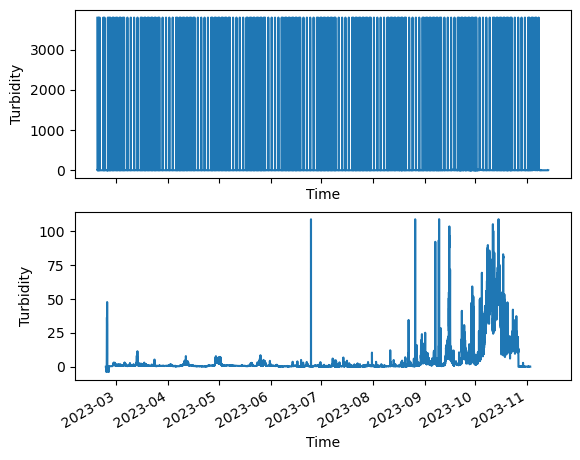

In [199]:
# Plot unfiltered turbidity timeseries from Seapoint sensors on NSIF and MFN
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
turbd1.plot.line(ax=axs[0])
turbd2.plot.line(ax=axs[1])

The turbidity from the NSIF Seapoint Turbidity sensor has data values greater than the expected range of the sensor, so we will apply a simple mask for values greater than 25 NTU (expected 0-25 NTU) to resolve the majority of the measured values in the time series. The expected range for the sensor on the NSIF referenced here is pulled from the At-Sea Test 3 Plan document. The Seapoint Turbidity sensor data sheet indicates that the maximum FTU (used in data sheet) value is only 4000 when gain is set to 1x. Gain should have been set to 100x for maximum readings of 25 FTU. The Deployment Info screenshot on the raw data repo shows that the sensor range was set to 25 NTU.

In [200]:
# Mask turbidity values from NSIF Seapoint over 25 NTU
turbd1 = turbd1.where(turbd1 <= 25)

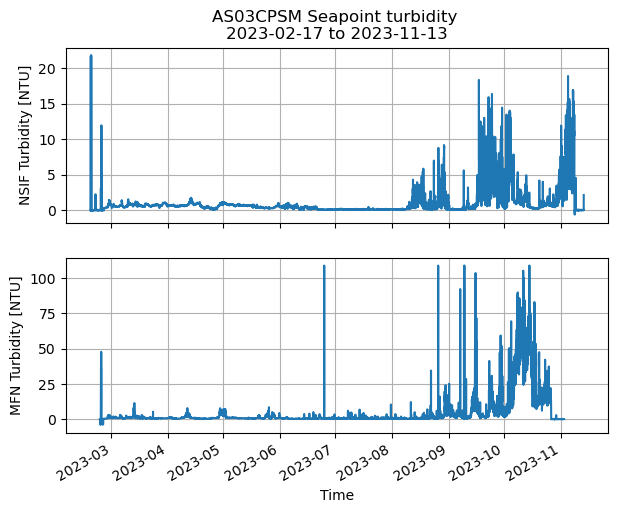

In [201]:
# Plot masked NSIF and same MFN Seapoint turbidity 
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=[7, 5])
turbd1.plot.line(ax=axs[0])
axs[0].grid()
axs[0].set_ylabel('NSIF Turbidity [NTU]')
axs[0].set_xlabel('')
turbd2.plot.line(ax=axs[1])
axs[1].grid()
axs[1].set_ylabel('MFN Turbidity [NTU]')
axs[0].set_title(f'AS03CPSM Seapoint turbidity \n{turbd1["Time"][0].values:.10} to {turbd1["Time"][-1].values:.10}')
# plt.savefig('figures/AS03CPSM_TURBD_full_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

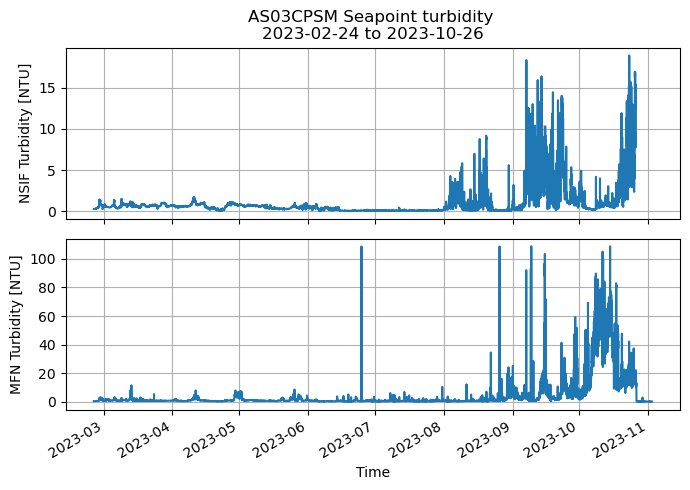

In [190]:
# Plot same figure as above but with telemetered NSIF TURBD
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=[7, 5], layout="tight")
turbd1_telem["turbidity"].sel(time=slice("2023-02-24T14:50", turbd1_telem["time"][-1])).plot.line(ax=axs[0])
axs[0].grid()
axs[0].set_ylabel('NSIF Turbidity [NTU]')
axs[0].set_xlabel('')
turbd2.sel(Time=slice("2023-02-24T14:50", turbd2["Time"][-1])).plot.line(ax=axs[1])
axs[1].grid()
axs[1].set_ylabel('MFN Turbidity [NTU]')
axs[0].set_title(f'AS03CPSM Seapoint turbidity \n2023-02-24 to {turbd1_telem["time"][-1].values:.10}')
# plt.savefig('figures/AS03CPSM_TURBD1(t)_TURBD2(ri)_full_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

### Plot Seapoint turbidity in July with smaller turbidity range

In [26]:
# Index Seapoint turbidity measured in July 2023
turbd1_jul = turbd1.sel(Time="July 2023")
turbd2_jul = turbd2.sel(Time="July 2023")

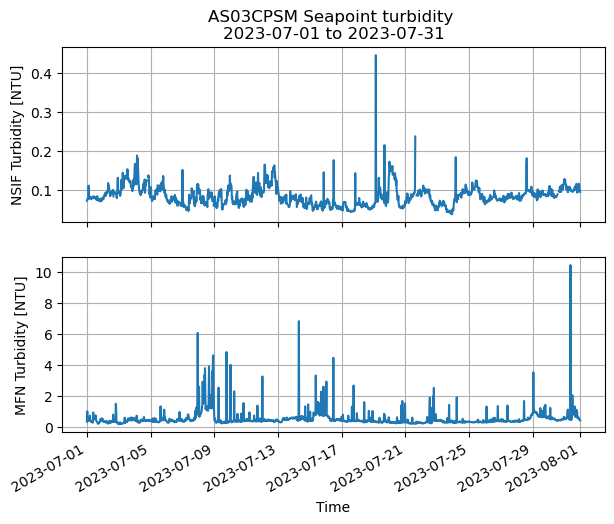

In [25]:
# Plot masked NSIF and same MFN Seapoint turbidity
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=[7, 5])
turbd1_jul.plot.line(ax=axs[0])
axs[0].grid()
axs[0].set_ylabel('NSIF Turbidity [NTU]')
axs[0].set_xlabel('')
turbd2_jul.plot.line(ax=axs[1])
axs[1].grid()
axs[1].set_ylabel('MFN Turbidity [NTU]')
axs[0].set_title(f'AS03CPSM Seapoint turbidity \n{turbd1_jul["Time"][0].values:.10} to {turbd1_jul["Time"][-1].values:.10}')
# plt.savefig('figures/AS03CPSM_TURBD_Jul2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

## Compare TURBD with turbidity from FLORT sensors

### Compare turbidity from flort1 and Seapoint recovered instrument turbidity on NSIF 

In [63]:
# Check several timestamp values to decide on origin for resample
flort1["time"][0:60]

<xarray.DataArray 'time' (time: 60)>
array(['2023-02-21T23:59:36.000000000', '2023-02-21T23:59:37.000000000',
       '2023-02-21T23:59:38.000000000', '2023-02-21T23:59:39.000000000',
       '2023-02-21T23:59:41.000000000', '2023-02-21T23:59:42.000000000',
       '2023-02-21T23:59:43.000000000', '2023-02-21T23:59:44.000000000',
       '2023-02-21T23:59:45.000000000', '2023-02-21T23:59:46.000000000',
       '2023-02-21T23:59:47.000000000', '2023-02-21T23:59:48.000000000',
       '2023-02-21T23:59:50.000000000', '2023-02-21T23:59:51.000000000',
       '2023-02-21T23:59:52.000000000', '2023-02-21T23:59:53.000000000',
       '2023-02-21T23:59:54.000000000', '2023-02-21T23:59:55.000000000',
       '2023-02-21T23:59:56.000000000', '2023-02-21T23:59:58.000000000',
       '2023-02-21T23:59:59.000000000', '2023-02-22T00:00:00.000000000',
       '2023-02-22T00:00:01.000000000', '2023-02-22T00:00:02.000000000',
       '2023-02-22T00:00:03.000000000', '2023-02-22T00:00:04.000000000',
       '2023-02-22T00:00:05.000000000', '2023-02-22T00:00:07.000000000',
       '2023-02-22T00:00:08.000000000', '2023-02-22T00:00:09.000000000',
       '2023-02-22T00:00:10.000000000', '2023-02-22T00:00:11.000000000',
       '2023-02-22T00:00:12.000000000', '2023-02-22T00:00:13.000000000',
       '2023-02-22T00:00:15.000000000', '2023-02-22T00:00:16.000000000',
       '2023-02-22T00:00:17.000000000', '2023-02-22T00:00:18.000000000',
       '2023-02-22T00:00:19.000000000', '2023-02-22T00:00:20.000000000',
       '2023-02-22T00:00:21.000000000', '2023-02-22T00:00:22.000000000',
       '2023-02-22T00:29:35.000000000', '2023-02-22T00:29:37.000000000',
       '2023-02-22T00:29:38.000000000', '2023-02-22T00:29:39.000000000',
       '2023-02-22T00:29:40.000000000', '2023-02-22T00:29:41.000000000',
       '2023-02-22T00:29:42.000000000', '2023-02-22T00:29:43.000000000',
       '2023-02-22T00:29:45.000000000', '2023-02-22T00:29:46.000000000',
       '2023-02-22T00:29:47.000000000', '2023-02-22T00:29:48.000000000',
       '2023-02-22T00:29:49.000000000', '2023-02-22T00:29:50.000000000',
       '2023-02-22T00:29:51.000000000', '2023-02-22T00:29:52.000000000',
       '2023-02-22T00:29:54.000000000', '2023-02-22T00:29:55.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2023-02-21T23:59:36 ... 2023-02-22T00:29:55

In [7]:
# Evaluate mean of each 1-min burst from FLORT sensor turbidity
flort1_ntu = flort1["backscatter_turb"]
flort1_resample = flort1_ntu.resample(time="30min", origin="start").mean()
flort1_resample

<xarray.DataArray 'backscatter_turb' (time: 11826)>
array([3.2648    , 3.2648    , 3.2648    , ..., 0.22411429, 0.24099512,
       0.28232195])
Coordinates:
  * time     (time) datetime64[ns] 2023-02-21T23:59:36 ... 2023-10-26T08:29:36

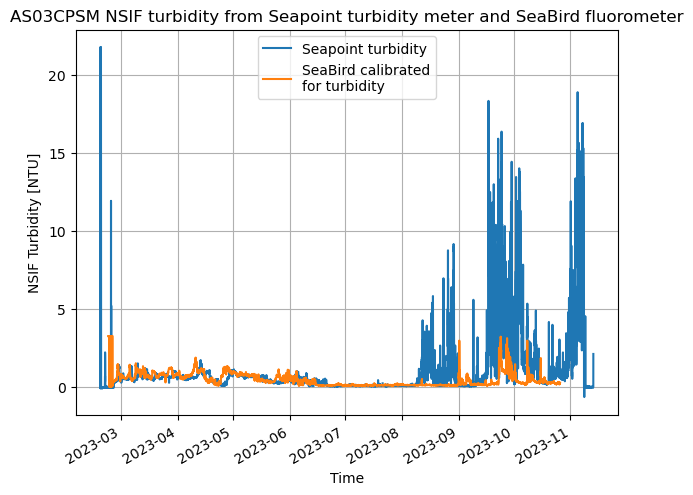

In [64]:
# Plot masked NSIF Seapoint turbidity (not smoothed) with turbidity from flort1 backscatter
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[7, 5])
turbd1.plot.line(ax=axs, label="Seapoint turbidity")
flort1_resample.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
axs.grid()
axs.set_ylabel('NSIF Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity from Seapoint turbidity meter and SeaBird fluorometer')
# plt.savefig('figures/AS03CPSM_TURBD1(ri)_FLORT1(rh-burst_mean)_full_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

In [ ]:
# Recreate plot for July 2023 with NSIF data from both sensors
# Select Seapoint turbidity measured in July 2023
turbd1_jul = turbd1.sel(Time="July 2023")
flort1_jul = flort1_resample.sel(time="July 2023")

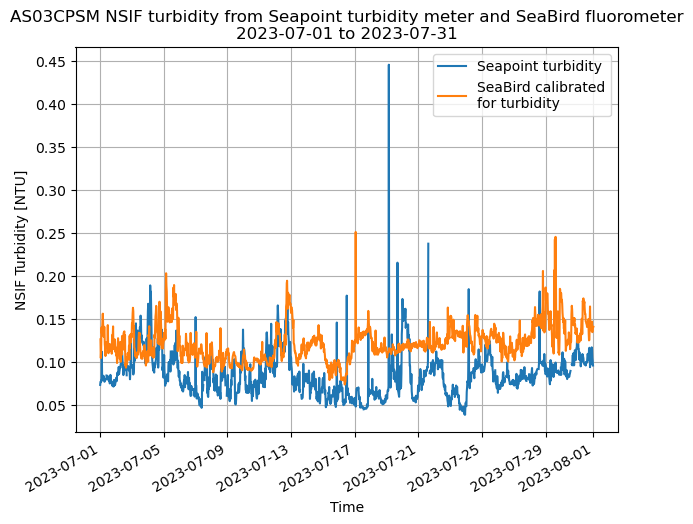

In [66]:
# Plot masked NSIF turbidity from Seapoint meter and FLORT-derived turbidity (burst average)
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[7, 5])
turbd1_jul.plot.line(ax=axs, label="Seapoint turbidity")
flort1_jul.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
axs.grid()
axs.set_ylabel('NSIF Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity from Seapoint turbidity meter and SeaBird fluorometer\n{turbd1_jul["Time"][0].values:.10} to {turbd1_jul["Time"][-1].values:.10}')
# plt.savefig('figures/AS03CPSM_TURBD1(ri)_FLORT1(rh-burst-mean)_Jul2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

In [9]:
# Create time series variables for March 2023
turbd1_mar = turbd1.sel(Time="March 2023")
flort1_mar = flort1_resample.sel(time="March 2023")

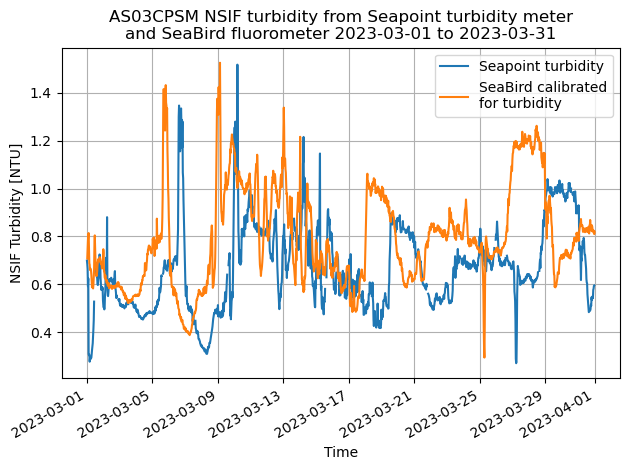

In [203]:
# Plot close-up of March 2023 with both TURBD1 and FLORT1 (burst average)
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, layout="tight")
turbd1_mar.plot.line(ax=axs, label="Seapoint turbidity")
flort1_mar.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
axs.grid()
axs.set_ylabel('NSIF Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity from Seapoint turbidity meter\nand SeaBird fluorometer {turbd1_mar["Time"][0].values:.10} to {turbd1_mar["Time"][-1].values:.10}')
# plt.savefig('figures/AS03CPSM_TURBD1(ri)_FLORT1(rh-burst-mean)_Mar2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

In [10]:
# Create time series variables for May 2023
turbd1_may = turbd1.sel(Time="May 2023")
flort1_may = flort1_resample.sel(time="May 2023")

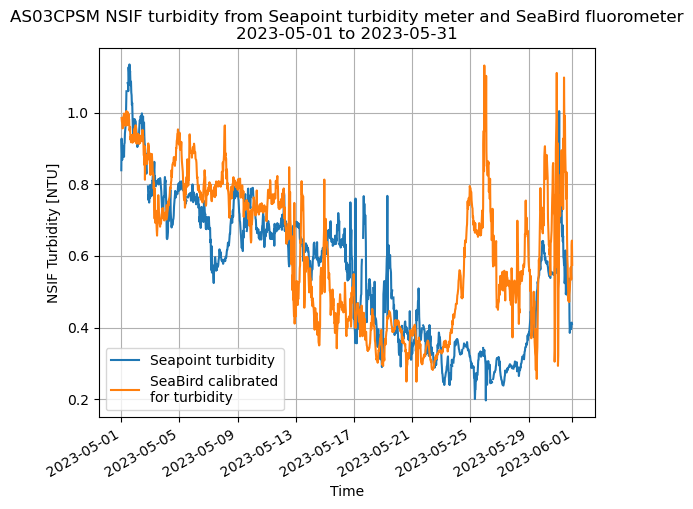

In [70]:
# Plot close-up of March 2023 with both TURBD1 and FLORT1 (burst average)
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True)
turbd1_may.plot.line(ax=axs, label="Seapoint turbidity")
flort1_may.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
axs.grid()
axs.set_ylabel('NSIF Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity from Seapoint turbidity meter and SeaBird fluorometer\n{turbd1_may["Time"][0].values:.10} to {turbd1_may["Time"][-1].values:.10}')
# plt.savefig('figures/AS03CPSM_TURBD1(ri)_FLORT1(rh-burst-mean)_May2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

#### Use 6-hr rolling median filter to smooth both signals and resolve daily variability

While the rolling median filtered data was ultimately not used in evaluating the performance of either sensor, it was helpful in observing an apparent time lag from erroneous values added to the recovered host NSIF TURBD data. 

In [85]:
# Remake full timeseries comparison after applying median smoothing to both timeseries
turbd1_6hr = turbd1.rolling(Time=12, center=True).median()
flort1_6hr = flort1_resample.rolling(time=12, center=True).median()

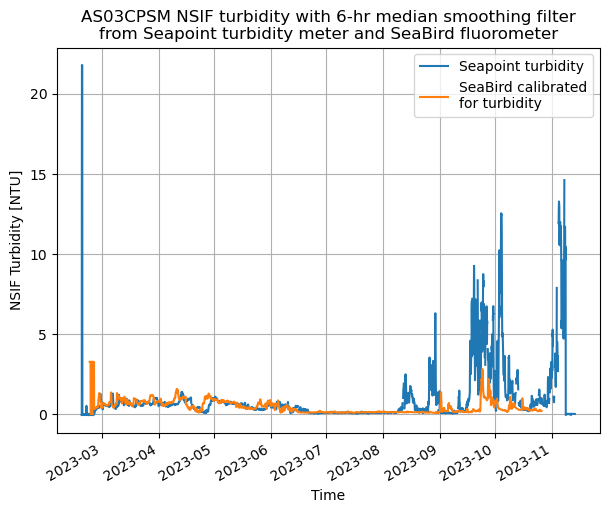

In [86]:
# Plot masked NSIF Seapoint turbidity (not smoothed) with turbidity from flort1 backscatter
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[7, 5])
turbd1_6hr.plot.line(ax=axs, label="Seapoint turbidity")
flort1_6hr.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
axs.grid()
axs.set_ylabel('NSIF Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity with 6-hr median smoothing filter\nfrom Seapoint turbidity meter and SeaBird fluorometer')
# plt.savefig('figures/AS03CPSM_TURBD1_FLORT1_full_6hrmedian_{today}.png'.format(today=date.today().strftime('%Y%m%d'))) # not saving just yet
plt.show()

In [87]:
# Remake July 2023 plot after applying median smoothing to both timeseries
turbd1_jul = turbd1_6hr.sel(Time="July 2023")
flort1_jul = flort1_6hr.sel(time="July 2023")

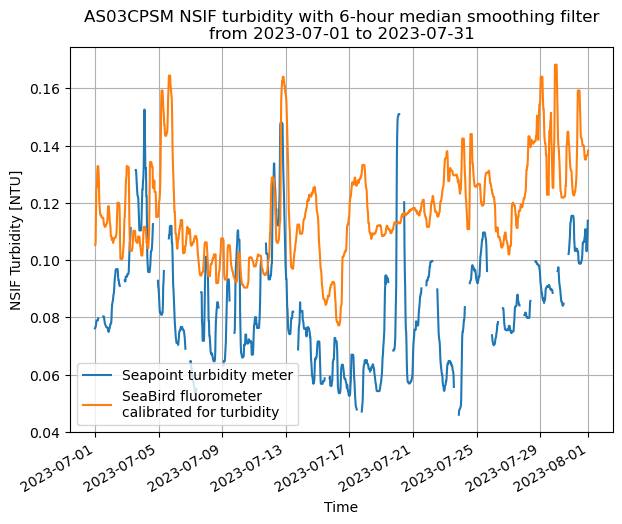

In [88]:
# Plot masked NSIF and same MFN Seapoint turbidity
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[7, 5])
turbd1_jul.plot.line(ax=axs, label="Seapoint turbidity meter")
flort1_jul.plot.line(ax=axs, label="SeaBird fluorometer\ncalibrated for turbidity")
axs.grid()
axs.set_ylabel('NSIF Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity with 6-hour median smoothing filter\nfrom {turbd1_jul["Time"][0].values:.10} to {turbd1_jul["Time"][-1].values:.10}')
# plt.savefig('figures/AS03CPSM_TURBD1_FLORT1_Jul2023_6hrmedian_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

In [89]:
# Remake May 2023 plot after applying median smoothing to both timeseries
turbd1_may = turbd1_6hr.sel(Time="May 2023")
flort1_may = flort1_6hr.sel(time="May 2023")

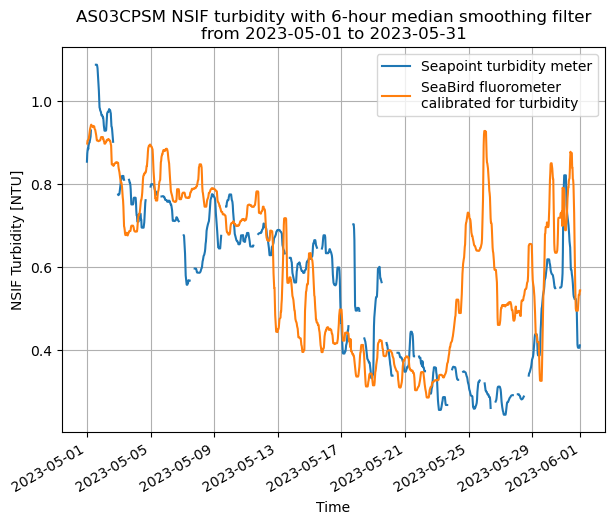

In [90]:
# Plot masked NSIF and same MFN Seapoint turbidity
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[7, 5])
turbd1_may.plot.line(ax=axs, label="Seapoint turbidity meter")
flort1_may.plot.line(ax=axs, label="SeaBird fluorometer\ncalibrated for turbidity")
axs.grid()
axs.set_ylabel('NSIF Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity with 6-hour median smoothing filter\nfrom {turbd1_may["Time"][0].values:.10} to {turbd1_may["Time"][-1].values:.10}')
# plt.savefig('figures/AS03CPSM_TURBD1_FLORT1_May2023_6hrmedian_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

In [92]:
# Remake March 2023 plot after applying median smoothing to both timeseries
turbd1_mar = turbd1_6hr.sel(Time="March 2023")
flort1_mar = flort1_6hr.sel(time="March 2023")

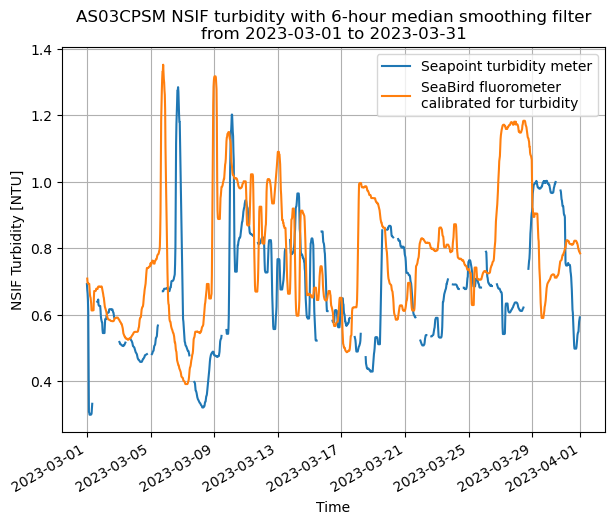

In [93]:
# Plot masked NSIF and same MFN Seapoint turbidity
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[7, 5])
turbd1_mar.plot.line(ax=axs, label="Seapoint turbidity meter")
flort1_mar.plot.line(ax=axs, label="SeaBird fluorometer\ncalibrated for turbidity")
axs.grid()
axs.set_ylabel('NSIF Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity with 6-hour median smoothing filter\nfrom {turbd1_mar["Time"][0].values:.10} to {turbd1_mar["Time"][-1].values:.10}')
# plt.savefig('figures/AS03CPSM_TURBD1_FLORT1_Mar2023_6hrmedian_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

### Compare turbidity from SeaBird flort2 and Seapoint recovered instrument turbd on MFN

In [9]:
# Checking flort2 time delta while reassigning just the turbidity data array to name flort2_ntu
flort2_ntu = flort2["backscatter_turb"]
flort2_ntu

<xarray.DataArray 'backscatter_turb' (time: 244578)>
array([122.4 , 122.4 , 122.4 , ...,   6.  ,   6.  ,   5.97])
Coordinates:
  * time     (time) datetime64[ns] 2023-02-23T23:59:46 ... 2023-10-26T22:58:13

The turbidity meter on the MFN was not connected to the same dcl as the flort, so it is also recording a sample every 30 mins like the turbd on the NSIF.
The flort on the MFN only sampled at 1 Hz for 1 minute at the start of every hour.
I will be selecting just the turbidity meter sample from the first half of the hour.
I also need to find the mean of each burst of the flort on the MFN, so I will use the same method as before with a time freq of 1 hour.

In [10]:
# Index tubidity meter samples from the MFN taken at the top of the hour
turbd2_mfn = turbd2.sel(Time=(turbd2.Time.dt.minute==00), method="nearest")
turbd2_mfn

<xarray.DataArray 'Turbidity' (Time: 6074)>
array([0.04279942, 0.04327754, 0.04279942, ..., 0.04303848, 0.04351661,
       0.06646668])
Coordinates:
  * Time     (Time) datetime64[ns] 2023-02-22T17:00:01 ... 2023-11-02T18:00:01

In [11]:
# Resample flort2 turbidity to 1 sample per hour with mean aggregation method
flort2_resample = flort2_ntu.resample(time="60min", origin="start").mean()
flort2_resample

<xarray.DataArray 'backscatter_turb' (time: 5879)>
array([122.4       , 122.4       , 122.4       , ...,   3.81488372,
         3.99146341,   6.03073171])
Coordinates:
  * time     (time) datetime64[ns] 2023-02-23T23:59:46 ... 2023-10-26T21:59:46

#### Time series of MFN turbidity from flort2 and turbidity meter 

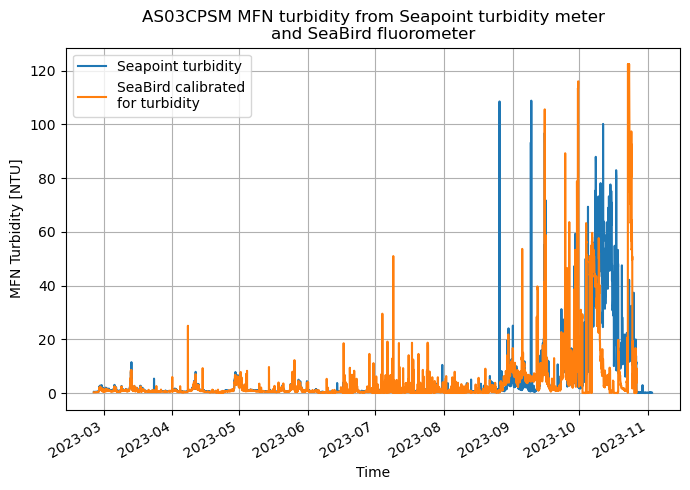

In [12]:
# Plot MFN Seapoint turbidity (not smoothed) with turbidity from flort2 backscatter after burst mean
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[7, 5], layout="tight")
turbd2_mfn.sel(Time=slice("2023-02-24T14:50", turbd2_mfn["Time"][-1])).plot.line(ax=axs, label="Seapoint turbidity")
flort2_resample.sel(time=slice("2023-02-24T14:50", flort2_resample["time"][-1])).plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
axs.grid()
axs.set_ylabel('MFN Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM MFN turbidity from Seapoint turbidity meter\nand SeaBird fluorometer')
# plt.savefig('figures/AS03CPSM_TURBD2(ri)_FLORT2(rh-burst-mean)_full_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

In [13]:
# Recreate plot for July 2023 with NSIF data from both sensors
# Select Seapoint turbidity measured in July 2023
turbd2_jul = turbd2_mfn.sel(Time="July 2023")
flort2_jul = flort2_resample.sel(time="July 2023")

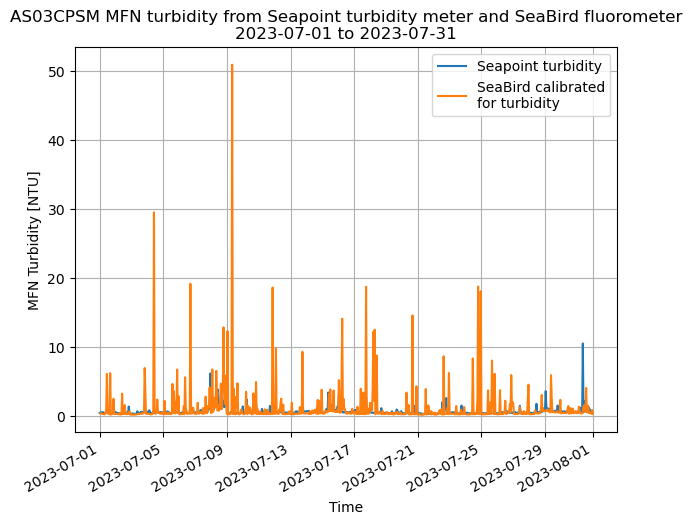

In [16]:
# Plot masked NSIF turbidity from Seapoint meter and FLORT-derived turbidity (burst mean)
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[7, 5])
turbd2_jul.plot.line(ax=axs, label="Seapoint turbidity")
flort2_jul.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
axs.grid()
axs.set_ylabel('MFN Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM MFN turbidity from Seapoint turbidity meter and SeaBird fluorometer\n{turbd2_jul["Time"][0].values:.10} to {turbd2_jul["Time"][-1].values:.10}')
# plt.savefig('figures/AS03CPSM_TURBD2(ri)_FLORT2(rh-burst-mean)_Jul2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

In [14]:
# Create time series variables for May 2023
turbd2_may = turbd2_mfn.sel(Time="May 2023")
flort2_may = flort2_resample.sel(time="May 2023")

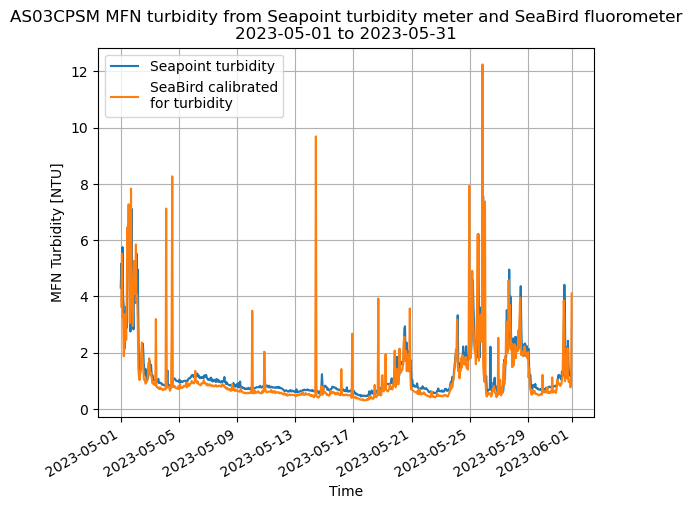

In [78]:
# Plot close-up of May 2023 with both TURBD2 and FLORT2 (burst mean)
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True)
turbd2_may.plot.line(ax=axs, label="Seapoint turbidity")
flort2_may.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
axs.grid()
axs.set_ylabel('MFN Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM MFN turbidity from Seapoint turbidity meter and SeaBird fluorometer\n{turbd2_may["Time"][0].values:.10} to {turbd2_may["Time"][-1].values:.10}')
# plt.savefig('figures/AS03CPSM_TURBD2(ri)_FLORT2(rh-burst-mean)_May2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

In [15]:
# Create time series variables for March 2023
turbd2_mar = turbd2_mfn.sel(Time="March 2023")
flort2_mar = flort2_resample.sel(time="March 2023")

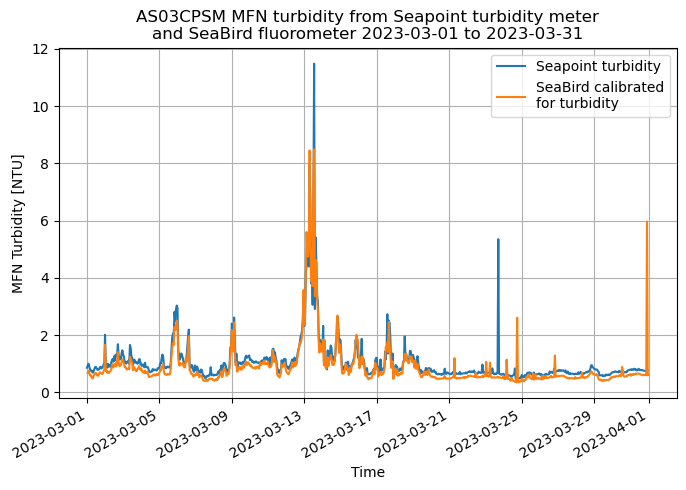

In [70]:
# Plot close-up of March 2023 with both TURBD2 and FLORT2 (burst mean)
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, layout="tight", figsize=[7, 5])
turbd2_mar.plot.line(ax=axs, label="Seapoint turbidity")
flort2_mar.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
axs.grid()
axs.set_ylabel('MFN Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM MFN turbidity from Seapoint turbidity meter\nand SeaBird fluorometer {turbd2_mar["Time"][0].values:.10} to {turbd2_mar["Time"][-1].values:.10}')
# plt.savefig('figures/AS03CPSM_TURBD2(ri)_FLORT2(rh-burst-mean)_Mar2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

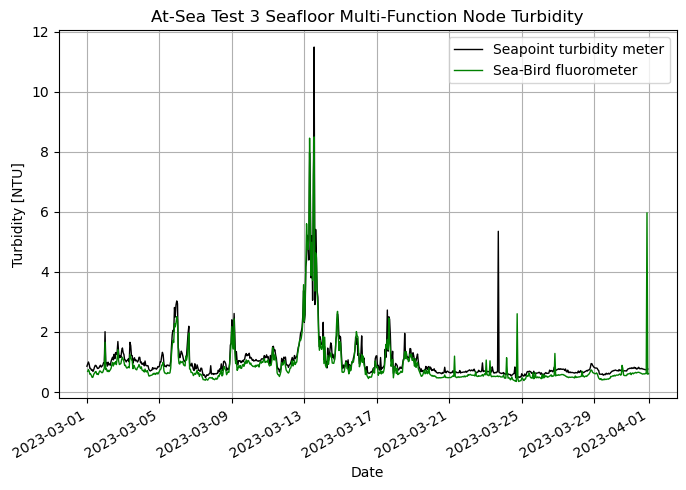

In [16]:
# Revise close-up of March 2023 with both TURBD2 and FLORT2 (burst mean) for newsletter
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, layout="tight", figsize=[7, 5])
turbd2_mar.plot.line(ax=axs, c="black", lw=1, label="Seapoint turbidity meter")
flort2_mar.plot.line(ax=axs, c="green", lw=1, label="Sea-Bird fluorometer")
axs.grid()
axs.set_ylabel('Turbidity [NTU]')
axs.set_xlabel('Date')
plt.legend()
axs.set_title(f'At-Sea Test 3 Seafloor Multi-Function Node Turbidity')
plt.show()

In [72]:
fig.savefig(
    'figures/AS03CPSM_TURBD2(ri)_FLORT2(rh-burst-mean)_Mar2023_timeseries_{today}.png'.format(
        today=date.today().strftime('%Y%m%d')))

In [17]:
# Find mean offset and standard deviation from mean between turbidity measurements
mfn_offset = turbd2_mar - flort2_mar
print([mfn_offset.mean(), mfn_offset.std()])

[<xarray.DataArray ()>
array(0.15710419), <xarray.DataArray ()>
array(1.15436661)]


In [81]:
# Given the apparent agreement between MFN turbidity options I want to get a closer look at Oct 2023
# when the signals are quite different.
turbd2_oct = turbd2_mfn.sel(Time="October 2023")
flort2_oct = flort2_resample.sel(time="October 2023")

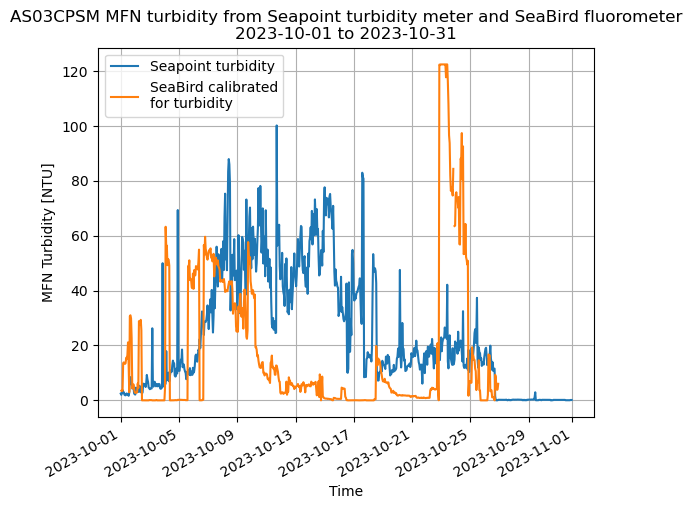

In [82]:
# Plot close-up of Oct 2023 with both TURBD2 and FLORT2 (burst mean)
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True)
turbd2_oct.plot.line(ax=axs, label="Seapoint turbidity")
flort2_oct.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
axs.grid()
axs.set_ylabel('MFN Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM MFN turbidity from Seapoint turbidity meter and SeaBird fluorometer\n{turbd2_oct["Time"][0].values:.10} to {turbd2_oct["Time"][-1].values:.10}')
# plt.savefig('figures/AS03CPSM_TURBD2(ri)_FLORT2(rh-burst-mean)_Oct2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

#### Linear regression of MFN turbidity signals to determine constant offset

In [281]:
# Use MFN Seapoint turbidity and arbitrary threshold of 2 NTU to index individual "events"
# and limit to turbidity measurements under 20 NTU (Assuming these are uncharacteristic of the area)
# We will exclude from Sept 2023 onwards, since the figure above shows how one of the sensors (likely the FLORT) is not measuring the water accurately
# Also starting data from start of March since there appears to be some outliers at the start before the mooring was actually in the water
turbd2_events = turbd2_mfn.where(turbd2_mfn>2, drop=True).where(turbd2_mfn<12, drop=True).sel(Time=slice("2023-02-24T14:50", "June 2023"))
flort2_events = flort2_resample.sel(time=(turbd2_events["Time"].values), method="nearest")

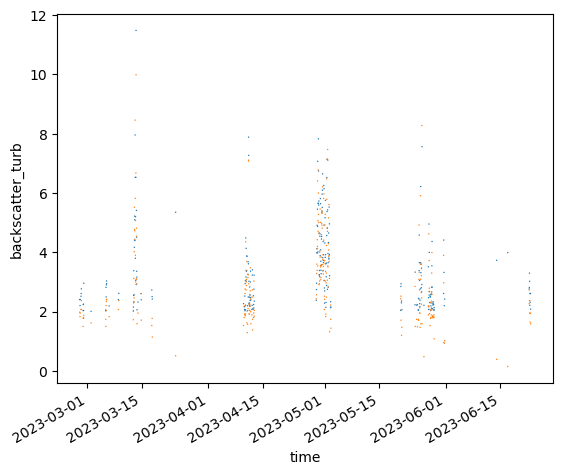

In [282]:
# Scatter of these points as a function of time to check indexing
fig, ax = plt.subplots(1, 1)
turbd2_events.plot.scatter(ax=ax, edgecolors="none", s=1)
flort2_events.plot.scatter(ax=ax, edgecolors="none", s=1)

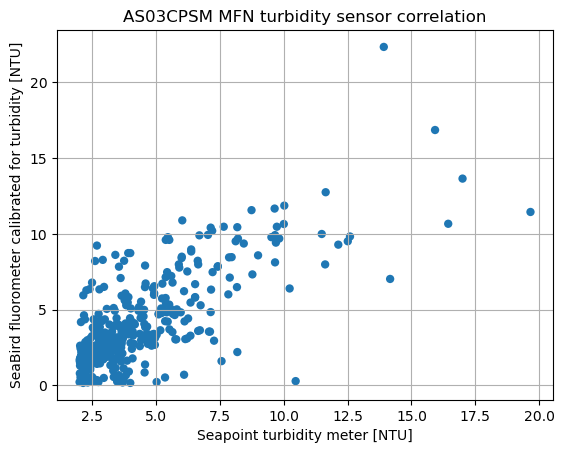

In [145]:
# Scatter of FLORT as a function of TURBD
fig, ax = plt.subplots(1, 1)
plt.scatter(turbd2_events.values, flort2_events.values, edgecolors="none")
plt.grid()
ax.set_xlabel("Seapoint turbidity meter [NTU]")
ax.set_ylabel("SeaBird fluorometer calibrated for turbidity [NTU]")
plt.title("AS03CPSM MFN turbidity sensor correlation")
plt.show()

In [149]:
# Expand dimensions of data arrays by 1 so that we can use the scikit-learn LinearRegression object
turbd2_expand = turbd2_events.expand_dims("feature", axis=1)
flort2_expand = flort2_events.expand_dims("feature", axis=1)

In [151]:
# Do a linear regression on these points to estimate a constant offset for this period
mfn_reg = LinearRegression().fit(turbd2_expand, flort2_expand)
mfn_reg.coef_

array([[0.85770309]])

In [152]:
mfn_reg.intercept_

array([0.31675638])

In [153]:
# Check R-squared score of fit
mfn_reg.score(turbd2_expand, flort2_expand)

0.5562614691000881

In [ ]:
# Create new scatter plot with linear regression line
x = np.linspace(turbd2_events.min().values, turbd2_events.max().values)
y = np.squeeze(mfn_reg.intercept_[0] + mfn_reg.coef_[[0]]*x)

fig, ax = plt.subplots(1, 1)
plt.scatter(turbd2_events.values, flort2_events.values, edgecolors="none")
plt.plot(x, y, '--', color="gray")
plt.grid()
ax.set_xlabel("Seapoint turbidity meter [NTU]")
ax.set_ylabel("SeaBird fluorometer calibrated for turbidity [NTU]")
plt.title("AS03CPSM MFN turbidity sensor correlation")
plt.show()

In [206]:
# Create a simple function to make the same plot as above with a linear regression line to reuse
def scatter_linreg(a, b, textx, texty, title):
    """Make a scatter plot of two data arrays a and b with b as a function of a.
    Then use scikit-learn LinearRegression object to evaluate the ordinary least
    squares fit to the data, and overlay the fit as a dashed gray line over the scatter plot.
    Includes the y-intercept, float, and R-squared score in text on the graph.
    In this version the x-axis and y-axis labels are hard-coded for comparison of turbidity measurements.

    Inputs:
    -------
    a, ndarray
    b, ndarray
    textx, float: x-position of lower left corner of text box on graph
    texty, float: y-position of lower left corner of text box on graph
    title, string: title for plot at the top of the figure

    Returns:
    --------
    fig, matplotlib.pyplot figure object
    ax, matplotlib.pyplot axes object
    """ 
    # Expand dimensions of data arrays by 1 so that we can use the scikit-learn LinearRegression object
    a_expand = a.expand_dims("feature", axis=1)
    b_expand = b.expand_dims("feature", axis=1)

    # Do a linear regression on these points to estimate a constant offset for this period
    reg = LinearRegression().fit(a_expand, b_expand)
    
    # Use LinearRegression results to create vectors for the plot
    x = np.linspace(a.min().values, a.max().values)
    y = np.squeeze(reg.intercept_[0] + reg.coef_[[0]]*x)

    # Scatter plot with linear regression line
    fig, ax = plt.subplots(1, 1)
    plt.scatter(a.values, b.values, edgecolors="none")
    plt.plot(x, y, '--', color="gray")
    plt.grid()
    ax.set_xlabel("Seapoint turbidity meter [NTU]")
    ax.set_ylabel("SeaBird fluorometer calibrated for turbidity [NTU]")
    plt.title(title)
    # Add text to show slope, intercept, and R-squared value for linear regression
    plt.text(textx, texty, "y-intercept: {:.3}\nslope: {:.3}\nR$^2$={:.3}".format(reg.intercept_[0], reg.coef_[0][0], reg.score(a_expand, b_expand)))
    plt.show()

    return fig, ax

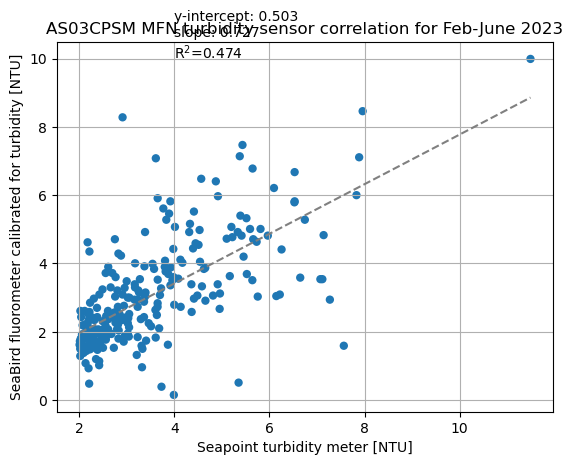

In [284]:
# Try out the new function
fig, ax = scatter_linreg(turbd2_events, flort2_events, 4, 10, "AS03CPSM MFN turbidity sensor correlation for Feb-June 2023")
# fig.savefig("figures/AS03CPSM_TURBD2(ri)_FLORT2(rh-burst-mean)_linregFebJune2023_{today}.png".format(today=date.today().strftime('%Y%m%d')))

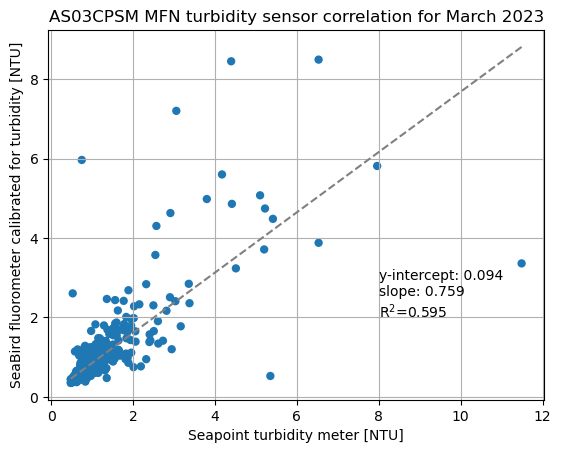

In [174]:
# Create a linear regression plot for March 2023 MFN data (all points)
fig, ax = scatter_linreg(turbd2_mar, flort2_mar, 8, 2, "AS03CPSM MFN turbidity sensor correlation for March 2023")
# fig.savefig("figures/AS03CPSM_TURBD2(ri)_FLORT2(rh-burst-mean)_linregMar2023_{today}.png".format(today=date.today().strftime('%Y%m%d')))

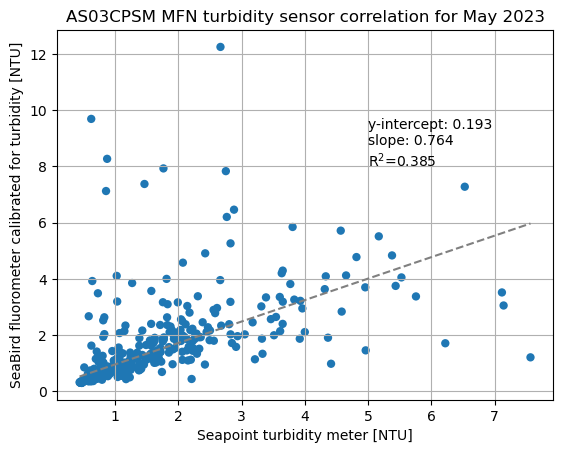

In [275]:
# Create a linear regression plot for May 2023 MFN data (all points)
fig, ax = scatter_linreg(turbd2_may, flort2_may, 5, 8, "AS03CPSM MFN turbidity sensor correlation for May 2023")
# fig.savefig("figures/AS03CPSM_TURBD2(ri)_FLORT2(rh-burst-mean)_linregMay2023_{today}.png".format(today=date.today().strftime('%Y%m%d')))

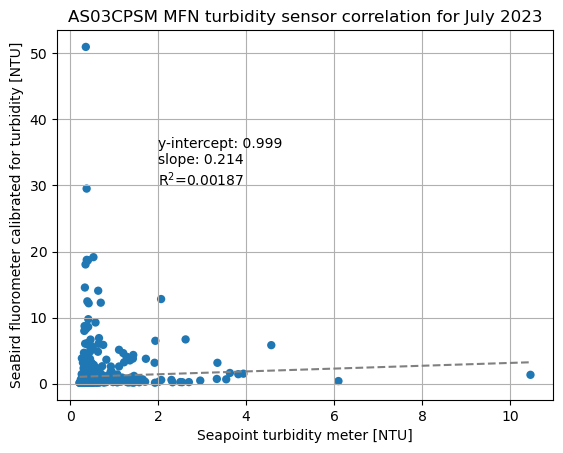

In [182]:
# Create a linear regression plot for MFN data in July 2023 (all points)
fig, ax = scatter_linreg(turbd2_jul, flort2_jul, 2, 30, "AS03CPSM MFN turbidity sensor correlation for July 2023")
# fig.savefig("figures/AS03CPSM_TURBD2(ri)_FLORT2(rh-burst-mean)_linregJul2023_{today}.png".format(today=date.today().strftime('%Y%m%d')))

### Compare both sensor measurements with cruise data from CTD casts

In [212]:
# Clean up the CTD cast data by dropping the first row, adding the correct column names, 
# converting time to an actual value, and then set time as the index
cast2_data = cast2_data.drop(index=0, axis=0)
cast2_data.rename(columns={0: "time",
                    2: "depth",
                    4: "temperature1",
                    5: "temperature2",
                    8: "salinity1",
                    9: "salinity2",
                    11: "fluorescence",
                    12: "beam transmission",
                    13: "beam attenuation",
                    14: "turbidity"
                }, inplace=True)

In [213]:
# Convert "time" to a datetime object and set as index
cast2_data.set_index(pd.to_datetime(cast2_data.time.astype(float), utc=True, unit="s", origin="2000-01-01T00:00:00"), inplace=True)
cast2_data.drop("time", axis=1, inplace=True)
cast2_data

depth temperature1 temperature2 salinity1  \
time                                                                    
2023-02-24 15:14:47+00:00   3.971      10.8219      10.8205   33.4870   
2023-02-24 15:15:10+00:00   4.963      10.7971      10.8082   33.4874   
2023-02-24 15:15:13+00:00   5.956      10.7324      10.7250   33.4916   
2023-02-24 15:15:15+00:00   6.949      10.6962      10.6960   33.4979   
2023-02-24 15:15:17+00:00   7.941      10.6854      10.6856   33.4999   
2023-02-24 15:15:19+00:00   8.934      10.6628      10.6638   33.5019   
2023-02-24 15:15:20+00:00   9.927      10.6388      10.6408   33.5027   
2023-02-24 15:15:22+00:00  10.919      10.6181      10.6181   33.5011   
2023-02-24 15:15:24+00:00  11.912      10.6006      10.6021   33.5019   
2023-02-24 15:15:26+00:00  12.905      10.5472      10.5472   33.4979   
2023-02-24 15:15:28+00:00  13.897      10.4890      10.4935   33.4950   
2023-02-24 15:15:30+00:00  14.890      10.4531      10.4556   33.4942   
2023-02-24 15:15:31+00:00  15.883      10.4157      10.4159   33.5007   
2023-02-24 15:15:33+00:00  16.875      10.4136      10.4136   33.5036   
2023-02-24 15:15:35+00:00  17.868      10.4121      10.4124   33.5088   
2023-02-24 15:15:37+00:00  18.860      10.3941      10.3944   33.5110   
2023-02-24 15:15:39+00:00  19.853      10.3772      10.3778   33.5649   
2023-02-24 15:15:40+00:00  20.846      10.3657      10.3667   33.6333   
2023-02-24 15:15:42+00:00  21.838      10.3779      10.3779   33.7735   
2023-02-24 15:15:44+00:00  22.831      10.3854      10.3854   33.8385   
2023-02-24 15:15:46+00:00  23.823      10.3866      10.3866   33.8435   
2023-02-24 15:15:48+00:00  24.816      10.3869      10.3868   33.8443   
2023-02-24 15:15:50+00:00  25.809      10.3869      10.3868   33.8442   
2023-02-24 15:15:51+00:00  26.801      10.3869      10.3870   33.8442   
2023-02-24 15:15:54+00:00  27.794      10.3871      10.3871   33.8438   
2023-02-24 15:15:57+00:00  28.786      10.3875      10.3874   33.8442   
2023-02-24 15:16:00+00:00  29.779      10.3874      10.3874   33.8440   
2023-02-24 15:16:34+00:00  30.771      10.3890      10.3887   33.8429   
2023-02-24 15:17:24+00:00  29.779      10.3893      10.3887   33.8437   
2023-02-24 15:17:16+00:00  28.786      10.3893      10.3892   33.8435   
2023-02-24 15:17:17+00:00  27.794      10.3889      10.3885   33.8436   
2023-02-24 15:17:19+00:00  26.801      10.3883      10.3880   33.8437   
2023-02-24 15:17:21+00:00  25.809      10.3879      10.3879   33.8438   
2023-02-24 15:17:24+00:00  24.816      10.3876      10.3876   33.8436   
2023-02-24 15:17:26+00:00  23.823      10.3876      10.3877   33.8437   
2023-02-24 15:17:27+00:00  22.831      10.3875      10.3874   33.8438   
2023-02-24 15:17:29+00:00  21.838      10.3868      10.3863   33.8415   
2023-02-24 15:17:31+00:00  20.846      10.3837      10.3819   33.8229   
2023-02-24 15:17:33+00:00  19.853      10.3794      10.3736   33.7799   
2023-02-24 15:17:36+00:00  18.860      10.3795      10.3774   33.7363   
2023-02-24 15:17:37+00:00  17.868      10.3795      10.3792   33.6950   
2023-02-24 15:17:39+00:00  16.875      10.3871      10.3925   33.6501   
2023-02-24 15:17:41+00:00  15.883      10.3937      10.4027   33.5924   
2023-02-24 15:17:43+00:00  14.890      10.4050      10.4044   33.5396   
2023-02-24 15:17:46+00:00  13.897      10.4086      10.4137   33.5255   
2023-02-24 15:17:48+00:00  12.905      10.4231      10.4413   33.5160   
2023-02-24 15:17:49+00:00  11.912      10.4889      10.4756   33.4970   
2023-02-24 15:17:52+00:00  10.919      10.5352      10.5142   33.4931   
2023-02-24 15:17:54+00:00   9.927      10.5256      10.5603   33.5006   
2023-02-24 15:17:56+00:00   8.934      10.5548      10.5706   33.4979   
2023-02-24 15:17:58+00:00   7.941      10.6005      10.6160   33.4969   
2023-02-24 15:18:00+00:00   6.949      10.6286      10.6348   33.4964   
2023-02-24 15:18:03+00:00   5.956      10.6369      10.6460   33.4997   
2023-02-24 15

In [217]:
# Convert data frame to an xarray dataset
cast2 = xr.Dataset(cast2_data)
cast2 = cast2.astype(float)
cast2 = cast2.assign_coords({"time": cast2_data.index.values})
cast2

<xarray.Dataset>
Dimensions:            (time: 56)
Coordinates:
  * time               (time) datetime64[ns] 2023-02-24T15:14:47 ... 2023-02-...
Data variables:
    depth              (time) float64 3.971 4.963 5.956 ... 4.963 3.971 2.978
    temperature1       (time) float64 10.82 10.8 10.73 ... 10.65 10.68 10.77
    temperature2       (time) float64 10.82 10.81 10.72 ... 10.67 10.71 10.73
    salinity1          (time) float64 33.49 33.49 33.49 33.5 ... 33.5 33.5 33.49
    salinity2          (time) float64 33.49 33.49 33.5 33.5 ... 33.5 33.49 33.5
    fluorescence       (time) float64 0.2413 0.2234 0.2529 ... 0.3014 0.3682
    beam transmission  (time) float64 92.5 92.5 92.47 ... 92.26 92.23 92.37
    beam attenuation   (time) float64 0.3118 0.3118 0.3131 ... 0.3236 0.3175
    turbidity          (time) float64 0.2347 0.2374 0.2455 ... 0.2391 0.2432

In [214]:
# Add scatter points of turbidity over short timeseries from NSIF
turbd1_cruise = turbd1_telem["turbidity"].sel(time=slice("2023-02-24T14:00:00", "2023-02-24T16:30:00"))
flort1_cruise = flort1_resample.sel(time=slice("2023-02-24T14:00:00", "2023-02-24T16:30:00"))

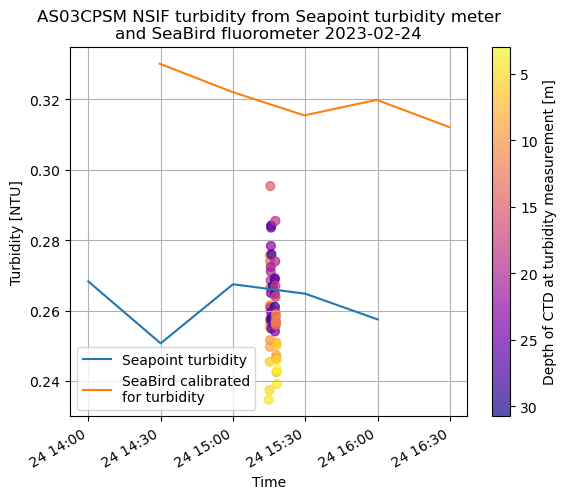

In [163]:
# Plot close-up of March 2023 with both TURBD1 and FLORT1 (burst mean)
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True)
turbd1_cruise.plot.line(ax=axs, label="Seapoint turbidity")
flort1_cruise.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
cast_scatt = plt.scatter(cast2["time"], cast2["turbidity"], c=cast2["depth"], cmap=cm._colormaps["plasma_r"], edgecolors="face", s=40, alpha=0.7)
axs.grid()
axs.set_ylabel('Turbidity [NTU]')
axs.set_xlabel('Time')
cbar = plt.colorbar(label="Depth of CTD at turbidity measurement [m]")
cbar.ax.invert_yaxis()
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity from Seapoint turbidity meter\nand SeaBird fluorometer {turbd1_cruise["time"][0].values:.10}')
# plt.savefig('figures/AS03CPSM_TURBD1(t)_FLORT1(rh-burst-mean)_Cast002_scatter_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

In [215]:
# Add scatter points of turbidity over short timeseries from MFN
turbd2_cruise = turbd2_mfn.sel(Time=slice("2023-02-24T14:00:00", "2023-02-24T16:30:00"))
flort2_cruise = flort2_resample.sel(time=slice("2023-02-24T14:00:00", "2023-02-24T16:30:00"))

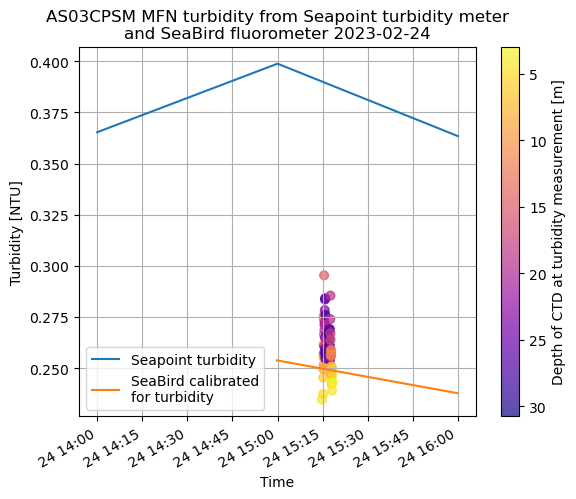

In [95]:
# Plot close-up of March 2023 with both TURBD1 and FLORT1 (burst mean)
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True)
turbd2_cruise.plot.line(ax=axs, label="Seapoint turbidity")
flort2_cruise.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
cast_scatt = plt.scatter(cast2["time"], cast2["turbidity"], c=cast2["depth"], cmap=cm._colormaps["plasma_r"], edgecolors="face", s=40, alpha=0.7)
axs.grid()
axs.set_ylabel('Turbidity [NTU]')
axs.set_xlabel('Time')
cbar = plt.colorbar(label="Depth of CTD at turbidity measurement [m]")
cbar.ax.invert_yaxis()
plt.legend()
axs.set_title(f'AS03CPSM MFN turbidity from Seapoint turbidity meter\nand SeaBird fluorometer {turbd2_cruise["Time"][0].values:.10}')
# plt.savefig('figures/AS03CPSM_TURBD2(ri)_FLORT2(rh-burst-mean)_Cast002_scatter_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

In [218]:
# Find index of maximum depth to split casts into down cast and upcast portions
maxdepth = cast2["depth"].argmax().values
maxdepth

array(27)

Text(0.5, 0.98, 'AST3 deployment CTD cast 002: 2023-02-24T15:14:00')

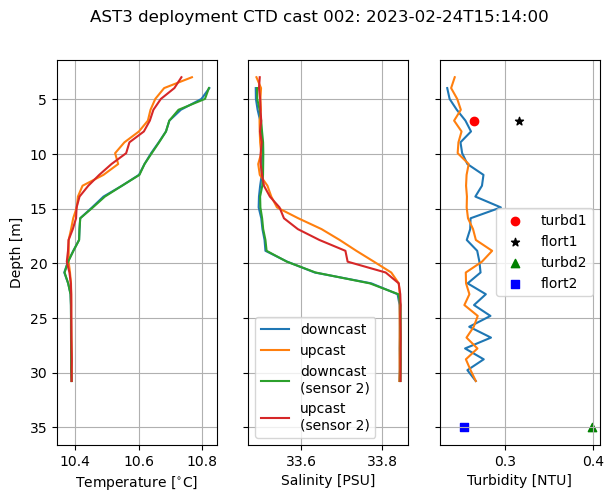

In [220]:
# Create profile figure with 6 panels for depth-dependent parameters
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(7, 5))

plt.subplot(131)
axs[0].invert_yaxis()
plt.plot(cast2["temperature1"][:maxdepth+1], cast2["depth"][:maxdepth+1],
         cast2["temperature1"][maxdepth:], cast2["depth"][maxdepth:],
         label="temperature 1")
plt.plot(cast2["temperature2"][:maxdepth+1], cast2["depth"][:maxdepth+1],
         cast2["temperature2"][maxdepth:], cast2["depth"][maxdepth:],
         label="temperature 2")
# plt.legend(["temperature 1 down", "temperature 1 up", "temperature 2 down", "temperature 2 up"])
plt.xlabel("Temperature [$^{\circ}$C]")
plt.ylabel("Depth [m]")
plt.grid()

plt.subplot(132)
# axs[1].invert_yaxis()
plt.plot(cast2["salinity1"][:maxdepth+1], cast2["depth"][:maxdepth+1],
         cast2["salinity1"][maxdepth:], cast2["depth"][maxdepth:],
         label="salinity 1")
plt.plot(cast2["salinity2"][:maxdepth+1], cast2["depth"][:maxdepth+1],
         cast2["salinity2"][maxdepth:], cast2["depth"][maxdepth:],
         label="salinity 2")
plt.legend(["downcast", "upcast", "downcast\n(sensor 2)", "upcast\n(sensor 2)"], loc="lower left")
plt.xlabel("Salinity [PSU]")
plt.grid()

# plt.subplot(163)
# plt.plot(cast2["fluorescence"][:maxdepth+1], cast2["depth"][:maxdepth+1],
#          cast2["fluorescence"][maxdepth:], cast2["depth"][maxdepth:],
#          label="fluorescence")
# # plt.legend(["fluorescence down", "fluorescence up"])
# plt.xlabel("Fluorescence [mg m$^{-3}$]")
# plt.grid()

# plt.subplot(164)
# plt.plot(cast2["beam transmission"][:maxdepth+1], cast2["depth"][:maxdepth+1],
#          cast2["beam transmission"][maxdepth:], cast2["depth"][maxdepth:],
#          label="beam transmission")
# # plt.legend(["beam transmission down", "beam transmission up"])
# plt.xlabel("Beam transmission [%]")
# plt.grid()

# plt.subplot(165)
# plt.plot(cast2["beam attenuation"][:maxdepth+1], cast2["depth"][:maxdepth+1],
#          cast2["beam attenuation"][maxdepth:], cast2["depth"][maxdepth:],
#          label="beam attenuation")
# # plt.legend(["beam attenuation down", "beam attenuation up"])
# plt.xlabel("Beam attenuation [m$^{-1}$]")
# plt.grid()

plt.subplot(133)
plt.plot(cast2["turbidity"][:maxdepth+1], cast2["depth"][:maxdepth+1],
         cast2["turbidity"][maxdepth:], cast2["depth"][maxdepth:],
         label="")
# plt.legend(["turbidity down", "turbidity up"])
plt.xlabel("Turbidity [NTU]")
plt.grid()
# Add scatter points for turbidity from the nsif and the mfn using time nearest to maxdepth time
# NSIF turbidity using 7 m instrument depth (from?)
plt.scatter(turbd1_telem["turbidity"].sel(time=cast2["time"][maxdepth].values, method="nearest").values, 7, c="red", label="turbd1") # gap in the data so no point plotted
plt.scatter(flort1_resample.sel(time=cast2["time"][maxdepth].values, method="nearest").values, 7, c='black', marker='*', label="flort1")
# MFN turbidity using 35 m instrument depth (1 m above surveyed mooring location)
plt.scatter(turbd2_mfn.sel(Time=cast2["time"][maxdepth].values, method="nearest").values, 35, c="green", marker="^", label="turbd2")
plt.scatter(flort2_resample.sel(time=cast2["time"][maxdepth].values, method="nearest").values, 35, c="blue", marker="s", label="flort2")
plt.legend(loc="center right")

plt.suptitle("AST3 deployment CTD cast 002: 2023-02-24T15:14:00")

In [221]:
# Save png of figure above
fig.savefig("figures/AS03CPSM_Cast002_TURBD(t)_FLORT(rh-burst-mean)_profile_{today}.png".format(today=date.today().strftime('%Y%m%d')))

#### Use cast bins in bottom mixed layer to find mean and standard deviation for near seafloor turbidity 

Based on the above profile from CTD cast 002, it appears that depth bins from ~23 m down to the seafloor may be considered within a well-mixed bottom layer at the central surface mooring location.

In [222]:
# Extract cast 002 data within bottom mixed layer 
cast2_floor = cast2.where(cast2["depth"]>=23, drop=True)
cast2_floor

<xarray.Dataset>
Dimensions:            (time: 15)
Coordinates:
  * time               (time) datetime64[ns] 2023-02-24T15:15:46 ... 2023-02-...
Data variables:
    depth              (time) float64 23.82 24.82 25.81 ... 25.81 24.82 23.82
    temperature1       (time) float64 10.39 10.39 10.39 ... 10.39 10.39 10.39
    temperature2       (time) float64 10.39 10.39 10.39 ... 10.39 10.39 10.39
    salinity1          (time) float64 33.84 33.84 33.84 ... 33.84 33.84 33.84
    salinity2          (time) float64 33.85 33.85 33.85 ... 33.85 33.85 33.85
    fluorescence       (time) float64 1.266 1.245 1.274 ... 1.238 1.324 1.286
    beam transmission  (time) float64 93.01 93.23 93.19 ... 93.26 93.34 93.29
    beam attenuation   (time) float64 0.29 0.2804 0.282 ... 0.2791 0.2757 0.2779
    turbidity          (time) float64 0.265 0.2836 0.2596 ... 0.2692 0.2541

In [223]:
# Evaluate mean turbidity and standard deviation in the bottom layer
turbd_floor_mu = cast2_floor["turbidity"].mean().values
turbd_floor_sigma = cast2_floor["turbidity"].std().values

In [224]:
print(turbd_floor_mu, turbd_floor_sigma)

0.26520666666666665 0.009487638741482987


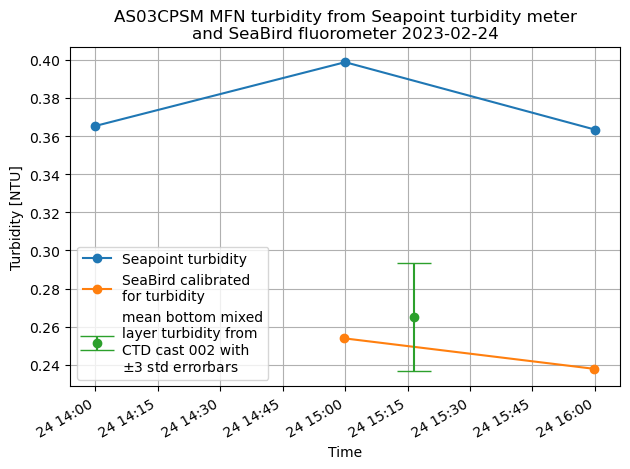

In [225]:
# Recreate MFN turbidity timeseries plot with cast 002 mean and std errorbars
fig, axs = plt.subplots(nrows=1, ncols=1, layout="tight")
turbd2_cruise.plot.line(ax=axs, label="Seapoint turbidity", marker="o")
flort2_cruise.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity", marker="o")
# cast_scatt = plt.scatter(cast2["time"], cast2["turbidity"], c=cast2["depth"], cmap=cm._colormaps["plasma_r"], edgecolors="face", s=40, alpha=0.7)
plt.errorbar(x=cast2["time"][maxdepth].values, y=turbd_floor_mu, yerr=3*turbd_floor_sigma,capsize=12, linestyle="", marker="o", label="mean bottom mixed\nlayer turbidity from\nCTD cast 002 with\n$\pm$3 std errorbars")
axs.grid()
axs.set_ylabel('Turbidity [NTU]')
axs.set_xlabel('Time')
# cbar = plt.colorbar(label="Depth of CTD at turbidity measurement [m]")
# cbar.ax.invert_yaxis()
plt.legend()
axs.set_title(f'AS03CPSM MFN turbidity from Seapoint turbidity meter\nand SeaBird fluorometer {turbd2_cruise["Time"][0].values:.10}')
# plt.savefig('figures/AS03CPSM_TURBD2(ri)_FLORT2(rh-burst-mean)_CTDcast002_bottom-layer-mean_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

### Redo time series plots with telemetered TURBD 

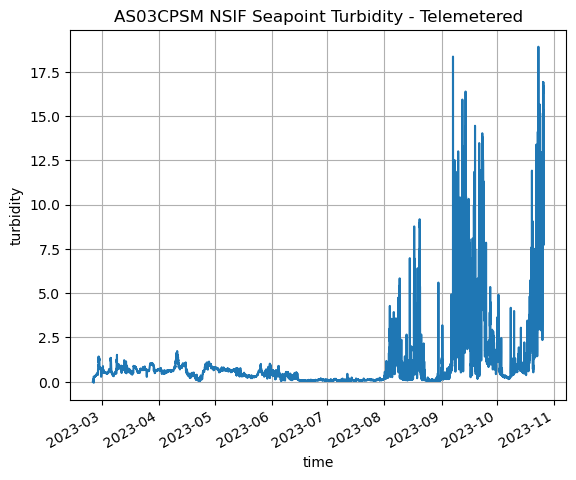

In [12]:
# Plot telemetered TURBD timeseries to check that there are no large values inserted
turbd1_telem["turbidity"].plot()
plt.title("AS03CPSM NSIF Seapoint Turbidity - Telemetered")
plt.grid()
# plt.savefig("figures/AS03CPSM_TURBD1(t)_timeseries_{today}.png".format(today=date.today().strftime('%Y%m%d')))

The unfiltered time series of turbidity telemetered from the NSIF shows the data without uncharacteristically large values inserted throughout. We also can see that this time series ends before Nov 2023, whereas the timeseries with inserted values continues on beyond the end of the deployment. I'm still not sure about why the turbidity suddenly jumps or becomes noisier after Aug 2023.

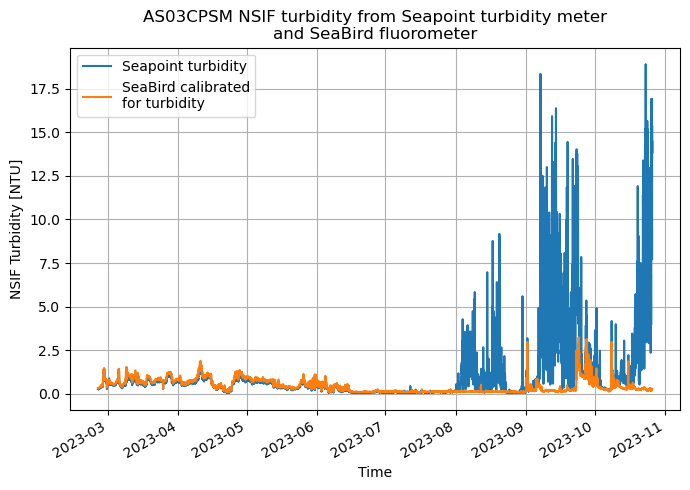

In [13]:
# Recreate full timeseries plot to compare NSIF TURBD (telemetered) with FLORTD (recovered host) calibrated for turbidity
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[7, 5], layout="tight")
turbd1_telem["turbidity"].sel(time=slice("2023-02-24T14:50", turbd1_telem["time"][-1])).plot.line(ax=axs, label="Seapoint turbidity")
flort1_resample.sel(time=slice("2023-02-24T14:50", flort1_resample["time"][-1])).plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
axs.grid()
axs.set_ylabel('NSIF Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity from Seapoint turbidity meter\nand SeaBird fluorometer')
# plt.savefig('figures/AS03CPSM_TURBD1(t)_FLORT1(rh-burst_mean)_full_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

This version of the full NSIF turbidity time series comparison seems to show better agreement between the Seapoint and SeaBird turbidity measurements, especially through the first 5 months. Next, I will check the months of March, May, and July for the same time-lag we could see before.

In [14]:
# Create time series variables for March 2023
turbd1_mar = turbd1_telem["turbidity"].sel(time="March 2023")
flort1_mar = flort1_resample.sel(time="March 2023")

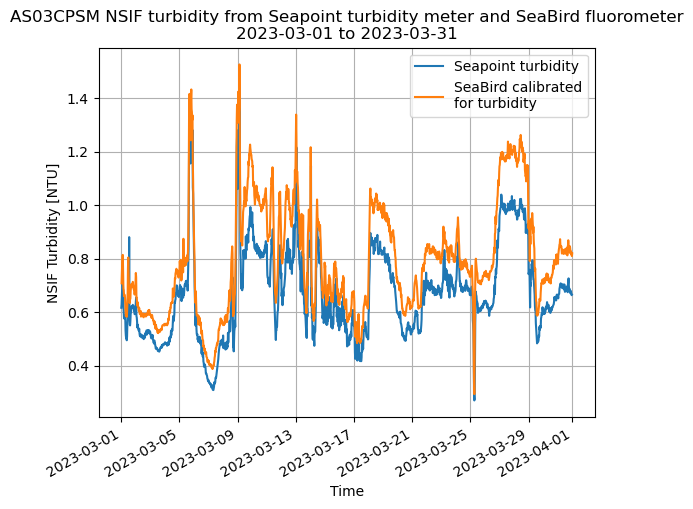

In [18]:
# Plot close-up of March 2023 with both TURBD1 (telemetered) and FLORT1 (burst average, recovered host)
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True)
turbd1_mar.plot.line(ax=axs, label="Seapoint turbidity")
flort1_mar.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
axs.grid()
axs.set_ylabel('NSIF Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity from Seapoint turbidity meter and SeaBird fluorometer\n{turbd1_mar["time"][0].values:.10} to {turbd1_mar["time"][-1].values:.10}')
# plt.savefig('figures/AS03CPSM_TURBD1(t)_FLORT1(rh-burst-mean)_Mar2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

In [22]:
# Calculate the mean difference between Seapoint and Sea-Bird turbidity in March
mar_mean = (flort1_mar.values - turbd1_mar.values).mean()
mar_std = (flort1_mar.values - turbd1_mar.values).std()
print(mar_mean, mar_std)

0.12211801599896906 0.06368940449634553


In [126]:
# Create time series variables for May 2023
turbd1_may = turbd1_telem["turbidity"].sel(time="May 2023")
flort1_may = flort1_resample.sel(time="May 2023")

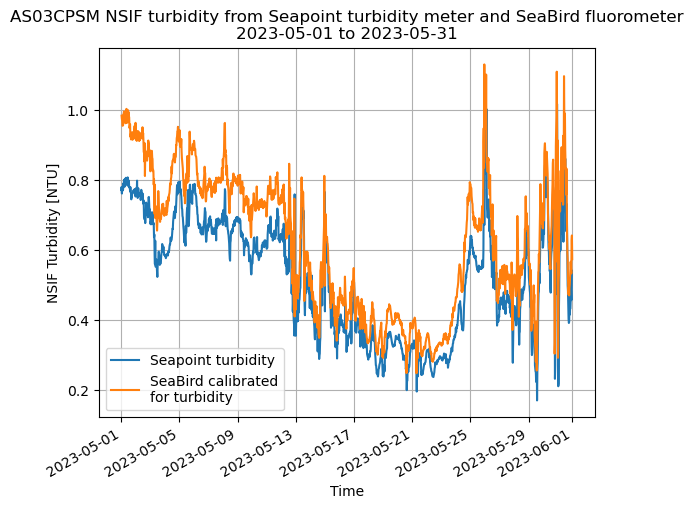

In [127]:
# Plot close-up of May 2023 with both TURBD1 and FLORT1 (burst average)
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True)
turbd1_may.plot.line(ax=axs, label="Seapoint turbidity")
flort1_may.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
axs.grid()
axs.set_ylabel('NSIF Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity from Seapoint turbidity meter and SeaBird fluorometer\n{turbd1_may["time"][0].values:.10} to {turbd1_may["time"][-1].values:.10}')
# plt.savefig('figures/AS03CPSM_TURBD1(t)_FLORT1(rh-burst-mean)_May2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

In [129]:
# Recreate plot for July 2023 with NSIF data from both sensors
# Select Seapoint turbidity measured in July 2023
turbd1_jul = turbd1_telem["turbidity"].sel(time="July 2023")
flort1_jul = flort1_resample.sel(time="July 2023")

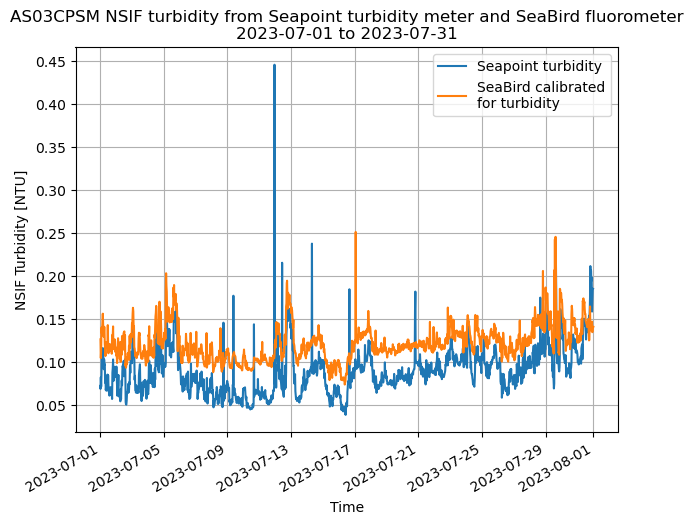

In [130]:
# Plot masked NSIF turbidity from Seapoint meter and FLORT-derived turbidity (burst average)
fig, axs = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=[7, 5])
turbd1_jul.plot.line(ax=axs, label="Seapoint turbidity")
flort1_jul.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity")
axs.grid()
axs.set_ylabel('NSIF Turbidity [NTU]')
axs.set_xlabel('Time')
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity from Seapoint turbidity meter and SeaBird fluorometer\n{turbd1_jul["time"][0].values:.10} to {turbd1_jul["time"][-1].values:.10}')
# plt.savefig('figures/AS03CPSM_TURBD1(t)_FLORT1(rh-burst-mean)_Jul2023_timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

These shorter time series support the claim that the time lag is not present in the telemetered Seapoint turbidity meter data. I wonder if the odd peaks that start to appear in the Seapoint turbidity around 9 July 2023 are the start of whatever issue or noise affects the signal from Aug 2023 through the end of the deployment. Next I will be looking into the offset between the two signals through a linear regression (using function written earlier). First for the time series as a whole, and then for March, May, and July 2023 individually. I don't expect the offset to change with time, although I wonder if there is a non-linear relationship with signal strength. By sight, I think the difference between the turbidity measurements increases as turbidity increases.

#### Find average offset between NSIF telemetered Seapoint turbidity and recovered host SeaBird turbidity

In [286]:
# Use NSIF Seapoint turbidity and arbitrary threshold of 0.5 NTU to index individual "events"
turbd1_events = turbd1_telem["turbidity"].where(turbd1_telem["turbidity"]>0.5, drop=True).sel(time=slice("2023-02-24T14:50","June 2023"))
flort1_events = flort1_resample.sel(time=(turbd1_events["time"].values), method="nearest")

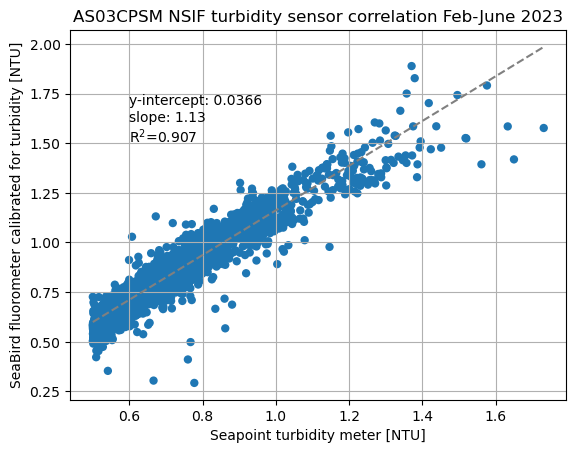

In [287]:
# Use function to do the linear regression and create figure and axes objects for turbidity >0.5 NTU
fig, ax = scatter_linreg(turbd1_events, flort1_events, 0.6, 1.50, "AS03CPSM NSIF turbidity sensor correlation Feb-June 2023")
# fig.savefig("figures/AS03CPSM_TURBD1(t)_FLORT1(rh-burst-mean)_linregFebJun2023_{today}.png".format(today=date.today().strftime('%Y%m%d')))

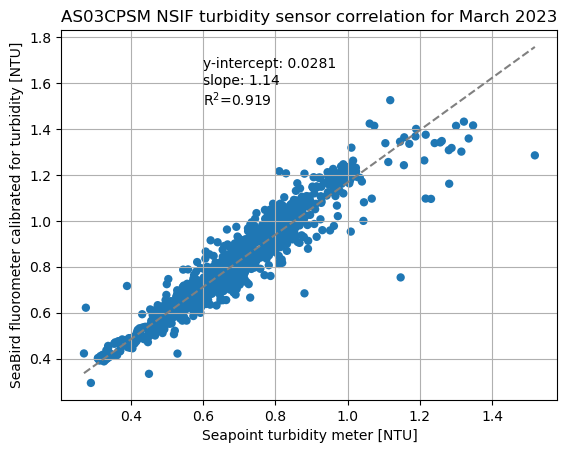

In [147]:
# Create correlation figure for Mar 2023
fig, ax = scatter_linreg(turbd1_mar, flort1_mar, 0.6, 1.50, "AS03CPSM NSIF turbidity sensor correlation for March 2023")
# fig.savefig("figures/AS03CPSM_TURBD1(t)_FLORT1(rh-burst-mean)_linregMar2023_{today}.png".format(today=date.today().strftime('%Y%m%d')))

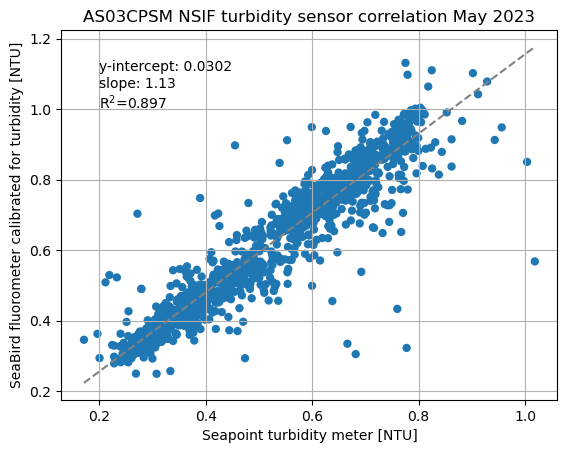

In [153]:
# Create correlation figure for May 2023
fig, ax = scatter_linreg(turbd1_may, flort1_may, 0.2, 1, "AS03CPSM NSIF turbidity sensor correlation May 2023")
# fig.savefig("figures/AS03CPSM_TURBD1(t)_FLORT1(rh-burst-mean)_linregMay2023_{today}.png".format(today=date.today().strftime('%Y%m%d')))

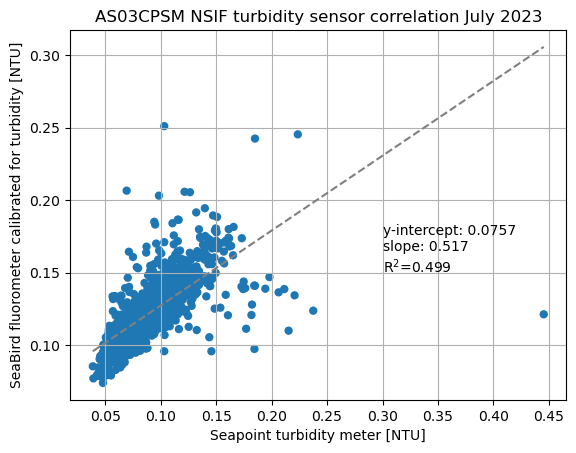

In [154]:
# Create correlation figure for July 2023
fig, ax = scatter_linreg(turbd1_jul, flort1_jul, 0.3, 0.15, "AS03CPSM NSIF turbidity sensor correlation July 2023")
# fig.savefig("figures/AS03CPSM_TURBD1(t)_FLORT1(rh-burst-mean)_linregJul2023_{today}.png".format(today=date.today().strftime('%Y%m%d')))

#### Plot NSIF time series with average surface mixed layer turbidity from CTD cast 002 

In [226]:
# Extract cast 002 data within surface mixed layer 
cast2_surf = cast2.where(cast2["depth"]<=10, drop=True)
cast2_surf

<xarray.Dataset>
Dimensions:            (time: 15)
Coordinates:
  * time               (time) datetime64[ns] 2023-02-24T15:14:47 ... 2023-02-...
Data variables:
    depth              (time) float64 3.971 4.963 5.956 ... 4.963 3.971 2.978
    temperature1       (time) float64 10.82 10.8 10.73 ... 10.65 10.68 10.77
    temperature2       (time) float64 10.82 10.81 10.72 ... 10.67 10.71 10.73
    salinity1          (time) float64 33.49 33.49 33.49 33.5 ... 33.5 33.5 33.49
    salinity2          (time) float64 33.49 33.49 33.5 33.5 ... 33.5 33.49 33.5
    fluorescence       (time) float64 0.2413 0.2234 0.2529 ... 0.3014 0.3682
    beam transmission  (time) float64 92.5 92.5 92.47 ... 92.26 92.23 92.37
    beam attenuation   (time) float64 0.3118 0.3118 0.3131 ... 0.3236 0.3175
    turbidity          (time) float64 0.2347 0.2374 0.2455 ... 0.2391 0.2432

In [227]:
# Evaluate mean turbidity and standard deviation in the surface layer
turbd_surf_mu = cast2_surf["turbidity"].mean().values
turbd_surf_sigma = cast2_surf["turbidity"].std().values

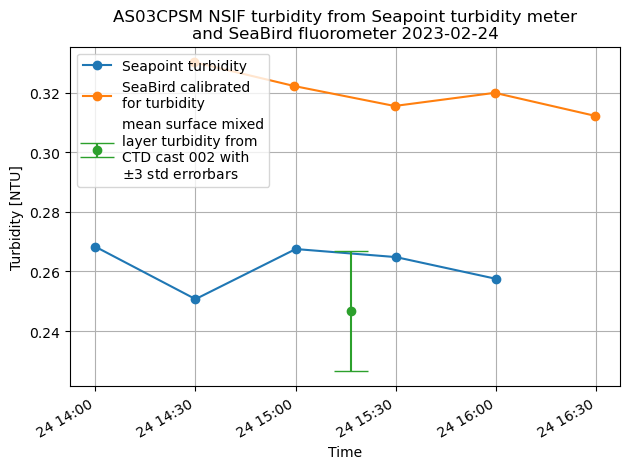

In [228]:
# Recreate NSIF turbidity timeseries plot with cast 002 mean and std errorbars
fig, axs = plt.subplots(nrows=1, ncols=1, layout="tight")
turbd1_cruise.plot.line(ax=axs, label="Seapoint turbidity", marker="o")
flort1_cruise.plot.line(ax=axs, label="SeaBird calibrated\nfor turbidity", marker="o")
# cast_scatt = plt.scatter(cast2["time"], cast2["turbidity"], c=cast2["depth"], cmap=cm._colormaps["plasma_r"], edgecolors="face", s=40, alpha=0.7)
plt.errorbar(x=cast2["time"][maxdepth].values, y=turbd_surf_mu, yerr=3*turbd_surf_sigma, capsize=12, linestyle="", marker="o", label="mean surface mixed\nlayer turbidity from\nCTD cast 002 with\n$\pm$3 std errorbars")
axs.grid()
axs.set_ylabel('Turbidity [NTU]')
axs.set_xlabel('Time')
# cbar = plt.colorbar(label="Depth of CTD at turbidity measurement [m]")
# cbar.ax.invert_yaxis()
plt.legend()
axs.set_title(f'AS03CPSM NSIF turbidity from Seapoint turbidity meter\nand SeaBird fluorometer {cast2["time"][maxdepth].values:.10}')
# plt.savefig('figures/AS03CPSM_TURBD1(t)_FLORT1(rh-burst-mean)_CTDcast002_surface-layer-mean-3std_{today}.png'.format(today=date.today().strftime('%Y%m%d')))
plt.show()

### Check ranges of TURBD and FLORT datasets

In [280]:
print("turbd1 data range: [{}, {}]".format(turbd1_telem["turbidity"].sel(
    time=slice("2023-02-24T14:50", "June 2023")).min().values, turbd1_telem["turbidity"].sel(
        time=slice("2023-02-24T14:50", "June 2023")).max().values))
print("flort1 data range: [{}, {}]".format(flort1_resample.sel(
    time=slice("2023-02-24T14:50", "June 2023")).min().values, flort1_resample.sel(
        time=slice("2023-02-24T14:50", "June 2023")).max().values))
print("turbd2 data range: [{}, {}]".format(turbd2_mfn.sel(
    Time=slice("2023-02-24T14:50", "June 2023")).min().values, turbd2_mfn.sel(
        Time=slice("2023-02-24T14:50", "June 2023")).max().values))
print("flort2 data range: [{}, {}]".format(flort2_resample.sel(
    time=slice("2023-02-24T14:50", "June 2023")).min().values, flort2_resample.sel(
        time=slice("2023-02-24T14:50", "June 2023")).max().values))

turbd1 data range: [0.041, 1.7316]
flort1 data range: [0.0824, 1.9052000000000002]
turbd2 data range: [0.20249366608959463, 11.486756959320246]
flort2 data range: [0.09, 9.99]


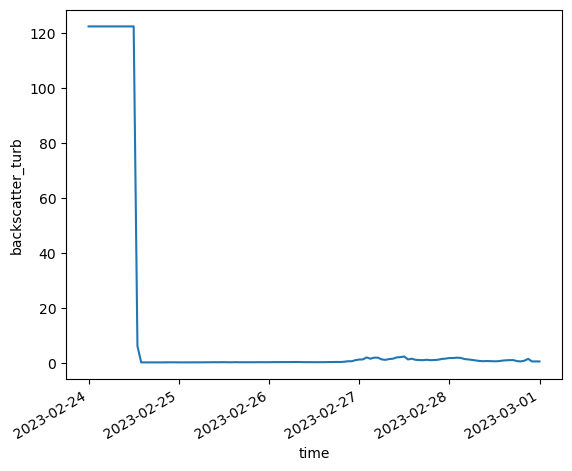

In [20]:
# The first peak in the MFN FLORT data shows some outliers at the start of the day on 24 Feb 2023,
# so we'll exclude these from the observed range. They appear to not represent normal operating conditions.
flort2_resample.sel(time=slice("Feb 2023")).plot()

## Check variability within FLORT sample burst

In [229]:
# Index FLORT sensor turbidity from AS03CPSM deployment to recovery
# Datetimes from Quick Look Cruise Reports 3211-00004 and 3211-00007
# flort1_ntu = flort1["backscatter_turb"].sel(time=slice("2023-02-24T14:46:00", "2023-10-26T16:22:00"))
flort1_ntu = flort1["backscatter_turb"].sel(time=slice("2023-04-01T05:30:00", "2023-04-01T10:30:00"))

In [230]:
# Plot 1 Apr 2023 time series from flort1
flort1_ntu.sel(time=slice("2023-04-01T00:45", "2023-04-01T01:15")).plot.line(figsize=(8,3))

TypeError: No numeric data to plot.

In [231]:
gb1 = flort1_ntu.groupby(flort1_ntu.time.dt.round("0.5H"))
len(gb1)

10

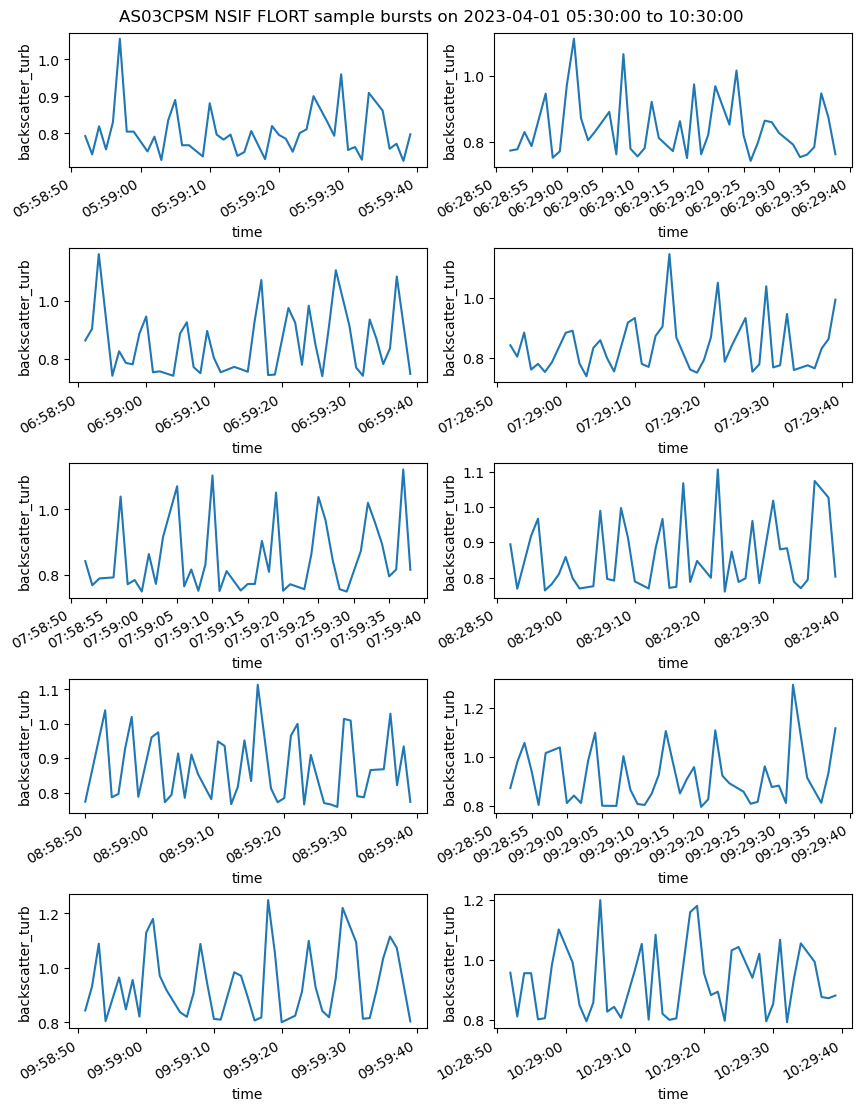

In [232]:
# Plot FLORT1 bursts to look for similarities in timing of peaks during a sampling burst
fig = plt.figure(figsize=(8.5, 11), layout="constrained")
plot = 1
for group_name, group_da in gb1:
    axs = fig.add_subplot(int(np.ceil(len(gb1)/2)), 2, plot)
    group_da.plot()
    plot += 1
plt.suptitle("AS03CPSM NSIF FLORT sample bursts on 2023-04-01 05:30:00 to 10:30:00")
# plt.savefig('figures/AS03CPSM_FLORT1(rh)_sample-burst-timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))


In [233]:
# Assigning just the flort2 turbidity data array to variable flort2_ntu for convenience
# flort2_ntu = flort2["backscatter_turb"].sel(time=slice("2023-02-24T14:46:00", "2023-10-26T16:22:00"))
flort2_ntu = flort2["backscatter_turb"].sel(time=slice("2023-04-01T00:30:00", "2023-04-01T10:30:00"))

In [234]:
# Sort FLORT2 data into individual bursts
gb2 = flort2_ntu.groupby(flort2_ntu.time.dt.round("0.5H"))

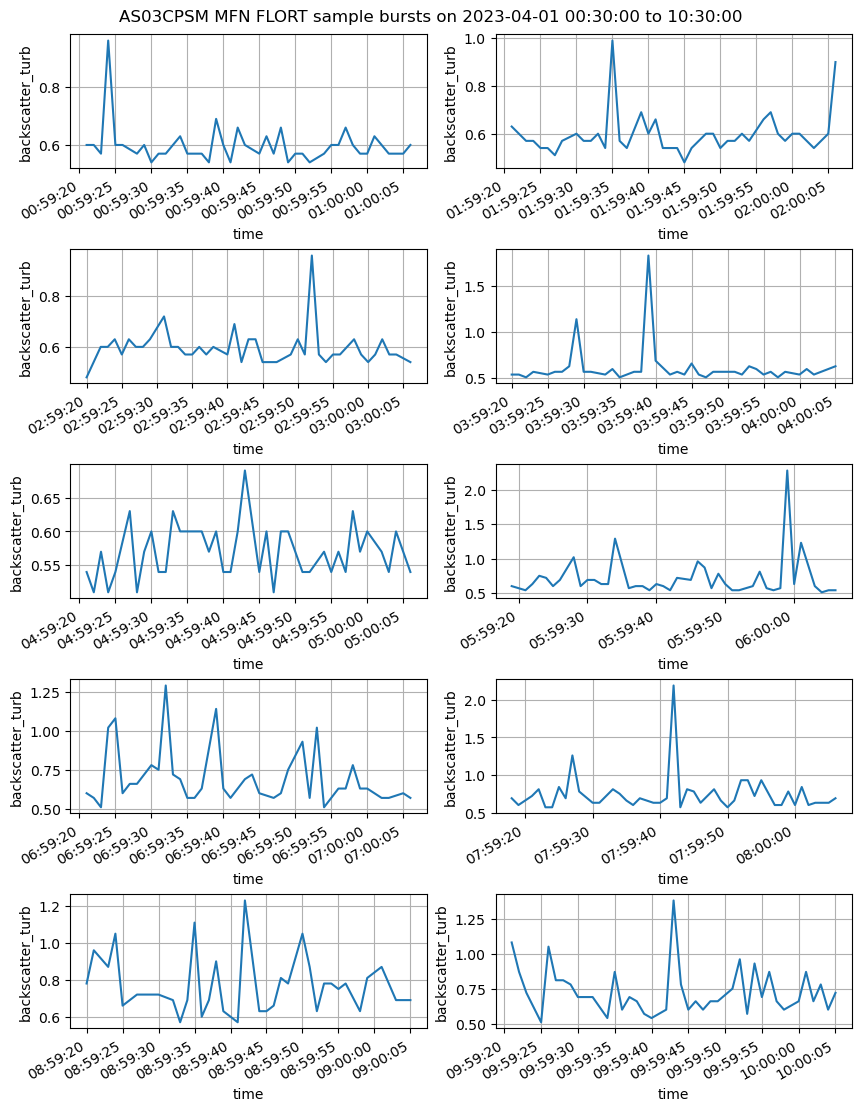

In [235]:
# Plot FLORT2 bursts to look for similarities in timing of peaks during a sampling burst
fig = plt.figure(figsize=(8.5,11), layout="constrained")
plot = 1
for group_name, group_da in gb2:
    axs = fig.add_subplot(int(np.ceil(len(gb2)/2)), 2, plot)
    group_da.plot()
    plt.grid()
    plot += 1
plt.suptitle("AS03CPSM MFN FLORT sample bursts on 2023-04-01 00:30:00 to 10:30:00")
# plt.savefig('figures/AS03CPSM_FLORT2(rh)_sample-burst-timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))

Text(0.5, 0.98, 'AS03CPSM MFN FLORT sample distribution\nby burst on 2023-04-01 00:30:00 to 10:30:00')

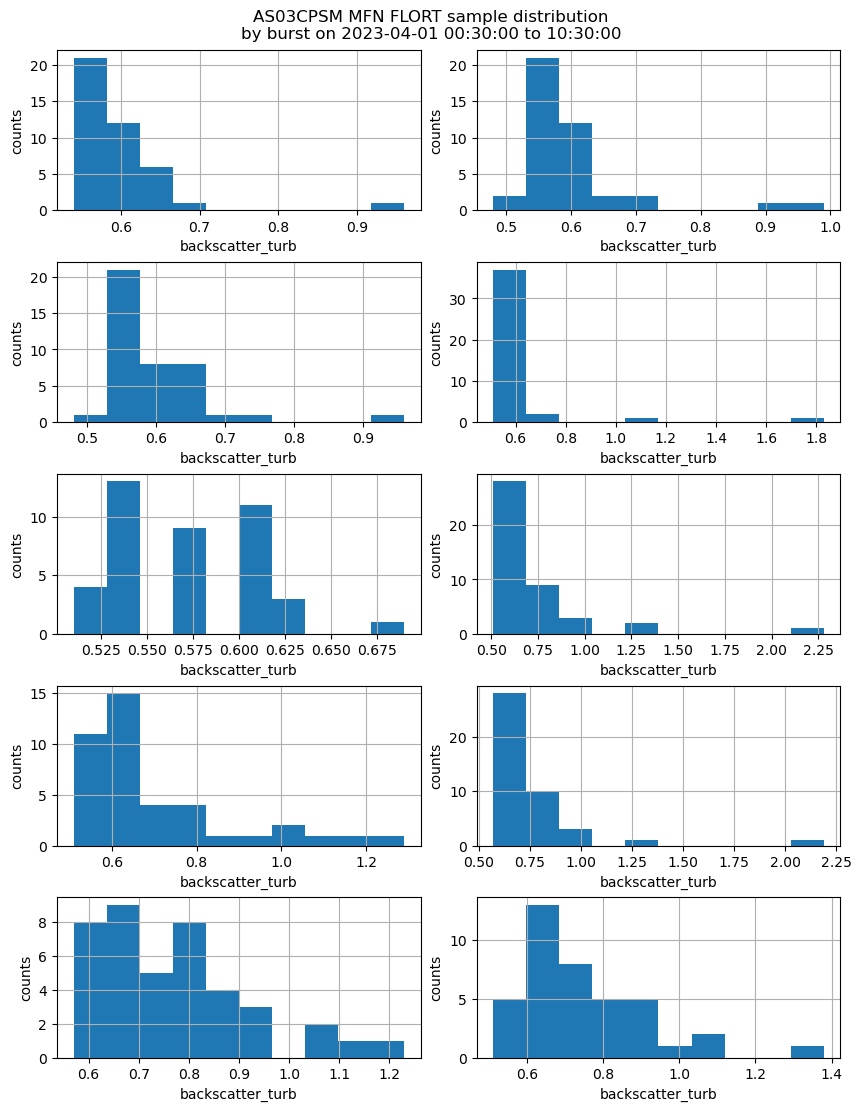

In [92]:
# Plot histograms of FLORT2 bursts to look for differences between spike magnitudes and noise floor
fig = plt.figure(figsize=(8.5, 11), layout="constrained")
plot = 1
for group_name, group_da in gb2:
    axs = fig.add_subplot(int(np.ceil(len(gb2)/2)), 2, plot)
    group_da.plot.hist()
    plt.grid()
    plt.ylabel("counts")
    plot += 1
plt.suptitle("AS03CPSM MFN FLORT sample distribution\nby burst on 2023-04-01 00:30:00 to 10:30:00")

Text(0.5, 1.0, 'SeaBird fluorometer burst sample distribution\nfor 2023-04-01 00:30:00 to 10:30:00')

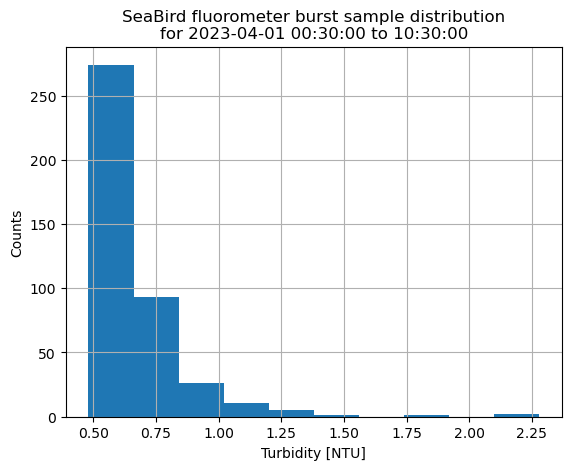

In [91]:
# Plot histogram of all FLORT2 burst samples to look for differences between spike magnitudes and noise floor
ct, bin_edges, bar = flort2_ntu.plot.hist()
plt.ylabel("Counts")
plt.xlabel("Turbidity [NTU]")
plt.grid()
plt.title("SeaBird fluorometer burst sample distribution\nfor 2023-04-01 00:30:00 to 10:30:00")
# from scipy.stats import norm
# mu, std = norm.fit(flort2_ntu)
# x = np.linspace(flort2_ntu.min(), flort2_ntu.max(), 50)
# p = norm.pdf(x, mu, std)
# plt.plot(x, p)


In [236]:
# Try 10 bursts on different days at different times
flort2_ntu = flort2["backscatter_turb"].sel(time=slice("2023-04-15T00:30:00", "2023-04-23T00:30:00"))
gb2 = flort2_ntu.groupby(flort2_ntu.time.dt.round("0.5H"))
group_list = list(gb2.groups)[0::20]
group_list

[numpy.datetime64('2023-04-15T01:00:00.000000000'),
 numpy.datetime64('2023-04-15T21:00:00.000000000'),
 numpy.datetime64('2023-04-16T17:00:00.000000000'),
 numpy.datetime64('2023-04-17T13:00:00.000000000'),
 numpy.datetime64('2023-04-18T09:00:00.000000000'),
 numpy.datetime64('2023-04-19T05:00:00.000000000'),
 numpy.datetime64('2023-04-20T01:00:00.000000000'),
 numpy.datetime64('2023-04-20T21:00:00.000000000'),
 numpy.datetime64('2023-04-21T17:00:00.000000000'),
 numpy.datetime64('2023-04-22T13:00:00.000000000')]

In [150]:
gb2[group_list[5]]

<xarray.DataArray 'backscatter_turb' (time: 41)>
array([0.27, 0.3 , 0.3 , 0.3 , 0.33, 0.24, 0.27, 0.27, 0.27, 0.3 , 0.33,
       0.33, 0.27, 0.45, 0.27, 0.24, 0.3 , 0.24, 0.27, 0.33, 0.27, 0.39,
       0.27, 0.3 , 0.33, 0.36, 0.3 , 0.36, 0.27, 0.33, 0.33, 0.3 , 0.3 ,
       0.27, 0.36, 0.3 , 0.3 , 0.27, 0.3 , 0.27, 0.27])
Coordinates:
  * time     (time) datetime64[ns] 2023-04-19T04:59:08 ... 2023-04-19T04:59:53

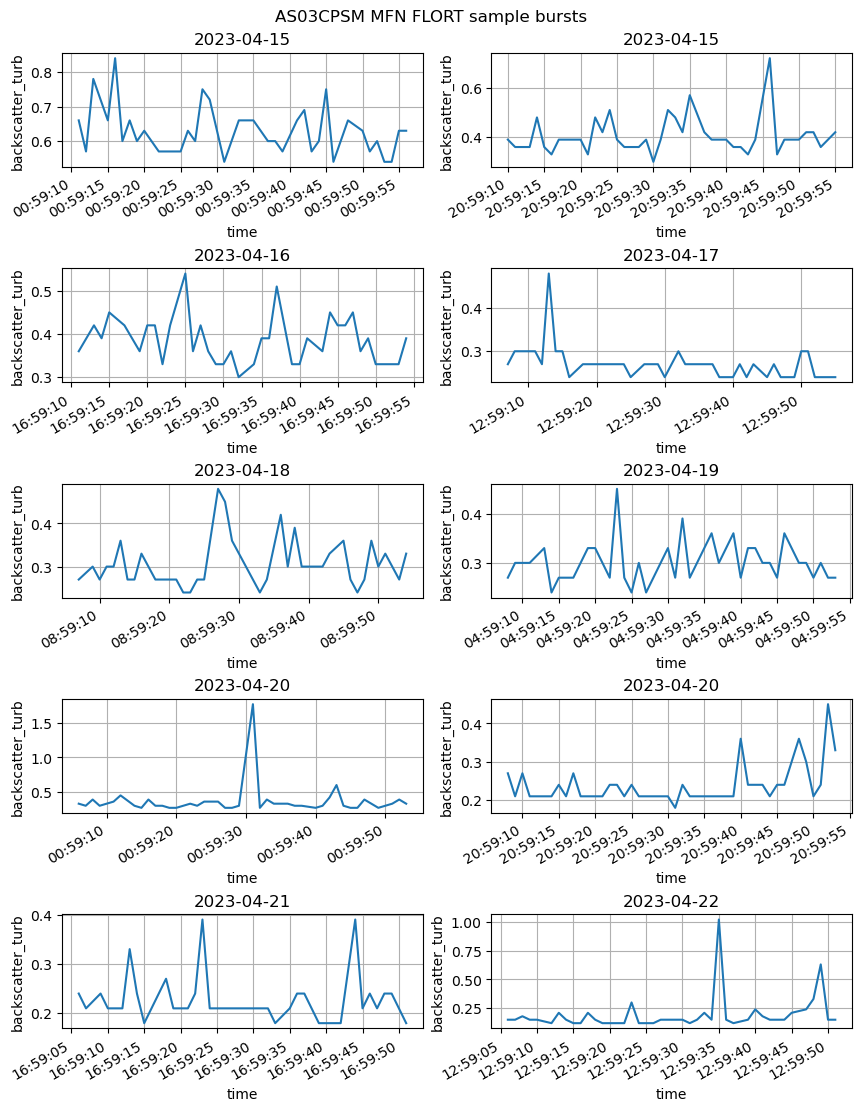

In [237]:
# Plot FLORT2 bursts to look for similarities in timing of peaks during a sampling burst
fig = plt.figure(figsize=(8.5,11), layout="constrained")
plot = 1
for key in group_list:
    axs = fig.add_subplot(int(np.ceil(len(group_list)/2)), 2, plot)
    gb2[key].plot()
    plt.grid()
    plt.title(str(key)[0:10])
    plot += 1
plt.suptitle("AS03CPSM MFN FLORT sample bursts")
# plt.savefig('figures/AS03CPSM_FLORT2(rh)_sample-burst-timeseries_{today}.png'.format(today=date.today().strftime('%Y%m%d')))